# Introduction to Sudoku and it's relevance to mathematics and computational complexity:

Sudoku puzzles, while popularly recognized as a recreational activity, embody profound mathematical and computational concepts. A solved Sudoku, essentially a special case of Latin squares, represents an n **2 x n **2 grid populated with n distinct numbers. These numbers are arranged so that each appears exactly once in every row and column, with the additional constraint that each number must also appear exactly once in each of the n subgrids. This structure not only captivates puzzle enthusiasts but also offers a rich canvas for mathematical exploration.

From a computational perspective, Sudoku presents a fascinating case study as an NP-Complete problem. This classification is pivotal in computational theory, characterized by two foundational properties:

1. Verifiability: The term NP denotes "Non-deterministic Polynomial time," highlighting that for any proposed solution to a problem, it's possible to verify its correctness within polynomial time. This attribute is crucial, ensuring that the verification process remains feasible even as problem sizes increase.

2. Transformation: A hallmark of NP-Completeness is the ability of every problem classified under NP to be transformed or reduced to any NP-Complete problem in polynomial time. Thus, solving an NP-Complete problem like Sudoku in polynomial time would imply a breakthrough in solving all NP problems, potentially revolutionizing fields such as bioinformatics, where it could impact the understanding and treatment of diseases through protein folding analysis.

The genesis of Sudoku as a specialized Latin square traces back further than often acknowledged, predating Leonhard Euler, a figure frequently associated with the concept. Remarkably, the inception of such puzzles can be traced to Choi Seok-jeong, a Korean mathematician who introduced these principles at least 67 years prior to Euler's contributions. The modern incarnation of Sudoku, however, emerged from Japan, where the puzzle company Nikoli introduced the distinctive rule concerning the uniqueness of numbers within subgrids. The term "Sudoku" itself is derived from the Japanese phrase "suuji wa dokushin ni kagiru," translating to "the numbers must remain single,"  capturing the essence of the puzzle.

Beyond their mathematical intrigue, Sudoku puzzles offer pragmatic insights into challenges encountered in graph theory, such as optimization problems akin to scheduling or frequency assignment. The analogy of filling a Sudoku grid mirrors the complexity of allocating resources like meeting times or broadcast frequencies without overlap, underscoring Sudoku's relevance in modeling and solving real-world problems through graph coloring techniques.

This exploration into Sudoku, from its historical roots to its implications in mathematical and computational theory, highlights the enduring fascination and utility of these puzzles. Through the lens of Sudoku, we gain a deeper appreciation for the intricate dance between numbers, logic, and the quest for order amidst complexity.

References:

Guyeux, Christophe, Nathalie M-L Côté, Jacques M Bahi, and Wojciech Bienia. "Is protein folding problem really a NP-complete one? First investigations." IEEE Explore, 2014. https://pubmed.ncbi.nlm.nih.gov/24467756/.

Choi, Seok-jeong. "Early Work on Latin Square Puzzles." Journal of Korean Mathematical Society 1650.

Euler, L. "An Observation on a New Type of Magic Square." Commentarii academiae scientiarum imperialis Petropolitanae 1776.

Goldreich, Oded. P, NP, and NP-Completeness: The Basics of Computational Complexity. Cambridge University Press, 2010.

In [1]:
import gzip
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
from timeit import default_timer as timer

In [2]:

with gzip.open("unique-3x3.tar.gz", "rb") as f:
    unique_3x3 = pickle.load(f)
    
unique_arr = np.array(unique_3x3)
sample_board = unique_arr[0]
# unique_arr

with gzip.open("non-unique-3x3.tar.gz", "rb") as f:
    non_unique_3x3 = pickle.load(f)

non_unique_arr = np.array(non_unique_3x3)
sample_non_unique_board = non_unique_arr[0]
# non_unique_arr

# Part 1

### Load samples

Loading two sets of Sudoku puzzle samples, one with unique solutions and another without unique solutions

In [3]:
with gzip.open("unique-3x3.tar.gz", "rb") as f:
    unique_3x3 = pickle.load(f)

In [4]:
unique_arr = np.array(unique_3x3)
sample_board = unique_arr[0]
# unique_arr

In [5]:
with gzip.open("non-unique-3x3.tar.gz", "rb") as f:
    non_unique_3x3 = pickle.load(f)

In [6]:
non_unique_arr = np.array(non_unique_3x3)
sample_non_unique_board = non_unique_arr[0]
# non_unique_arr

### Implement backtrack with partial solutions

Two functions, is_consistent_colouring and backtrack_k_colouring_partial, are implemented to perform the graph colouring.

The is_consistent_colouring function checks if a given coloring of the vertices (cells in the Sudoku puzzle) is valid by ensuring no adjacent vertices share the same color - number in the context of Sudoku.

In [7]:
def is_consistent_colouring(G, colours, v, verbose=False):
    # Check that no neighbour of v shares that colour
    for u in G.neighbors(v):
        if colours[u] == colours[v]:
            if verbose:
                print(f"{colours} is not consistent because of the edge {set([u, v])}, will not extend it")
            return False

    if verbose:
        print(f"{colours} seems consistent, will try to extend it")
    return True

The backtrack_k_colouring_partial function is a recursive backtracking algorithm that tries to color a graph, or the Sudoku board, with k colors. It respects the constraints of the coloring - the Sudoku rules.

In [8]:
def backtrack_k_colouring_partial(G, initial_values, k, verbose=False):
    # Line 1: Initialise the data we need.
    # Use initial_values to hold the initial partial state of the graph.
    colours = []
    colours.extend(initial_values)
    
    n = len(G.nodes())
    
    def next_cell():
        for i in range(len(colours)):
            if colours[i] == 0:
                return i
        return None

    # Define the recursive backtrack function
    def dive():
        # Find the next vertex (cell) to color
        v = next_cell()
        
        # All cells are coloured so there is a solution
        if v is None:
            # Check that it is a full solution
            for u, v in G.edges():
                if colours[u] == colours[v]:
                    # This is not a valid colouring
                    return None
                
            if verbose:
                print(f"{colours} is a full solution, returning it up the chain")
            
            return colours

        # Go through each way of extending partial solution
        for col in range(1, k + 1):
            # Temporarily extend partial solution
            colours[v] = col
            
            # Check temporary solution
            if is_consistent_colouring(G, colours, v, verbose):
                res = dive()
                
                # If a solution is returned, it means its a correct one
                if res is not None:
                    return res

            # Get rid of temporary solution
            colours[v] = 0

        # No solution found from this partial solution, return None
        if verbose:
            print(f"{colours} seemed consistent but couldn't be extended")
            
        return None

    # Line 10: Trigger recursion
    return dive()


### Implement function that puts a sudoku board on a graph
##### Nodes are considered adjacent if they are on the same row, column or box. This is to ensure that each row, column and box have one of each "colour" or number
The array_to_graph function converts a Sudoku board into a graph where each cell is a vertex, and edges are added between vertices that cannot share the same number according to Sudoku rules (same row, column, or box).


In [9]:
def array_to_graph(sudoku_board, n):
    # Initialize an empty graph
    G = nx.Graph()
    
    # Add nodes for each cell in the Sudoku board
    for i in range(n**4):
        G.add_node(i)
    
    # Helper function to get the box index
    def box_index(row, col):
        return (row // n) * n + (col // n)
    
    # Add edges based on Sudoku constraints
    for i in range(n**4):
        row_i, col_i = divmod(i, n**2)
        box_i = box_index(row_i, col_i)
        
        for j in range(i + 1, n**4):
            row_j, col_j = divmod(j, n**2)
            box_j = box_index(row_j, col_j)
            
            # Check if cells are in the same row, column, or box
            if row_i == row_j or col_i == col_j or box_i == box_j:
                G.add_edge(i, j)
    
    return G

### Test the solution

In [10]:
def test_solution(G, board, n):
    for i in range(len(board)):
        if not is_consistent_colouring(G, board, i):
            return False
    
    return True

In [11]:
def solve_board(board, n):
    G = array_to_graph(board, n)
    
    back_res = backtrack_k_colouring_partial(G, board, n**2)

    if not test_solution(G, back_res, n):
        raise Exception("Incorrect solution")

    nd_res = []
    for i in range(0, len(back_res), n**2):
        nd_res.append(back_res[i:i+(n**2)])

    return nd_res

### Finalise solution

#### Unique set

In [12]:
solutions = []
for board in unique_arr:
    s = solve_board(board, 3)
    solutions.append(s)

solutions

[[[5, 3, 4, 2, 8, 7, 1, 6, 9],
  [8, 1, 7, 5, 6, 9, 2, 3, 4],
  [2, 6, 9, 1, 4, 3, 5, 8, 7],
  [4, 2, 1, 7, 9, 6, 8, 5, 3],
  [3, 8, 6, 4, 1, 5, 7, 9, 2],
  [7, 9, 5, 3, 2, 8, 6, 4, 1],
  [9, 5, 2, 8, 3, 1, 4, 7, 6],
  [1, 7, 3, 6, 5, 4, 9, 2, 8],
  [6, 4, 8, 9, 7, 2, 3, 1, 5]],
 [[1, 8, 9, 2, 5, 3, 4, 6, 7],
  [4, 7, 2, 1, 6, 8, 9, 5, 3],
  [3, 5, 6, 4, 9, 7, 8, 1, 2],
  [8, 3, 4, 5, 2, 1, 7, 9, 6],
  [9, 2, 1, 7, 4, 6, 3, 8, 5],
  [5, 6, 7, 3, 8, 9, 2, 4, 1],
  [6, 4, 3, 8, 1, 2, 5, 7, 9],
  [7, 9, 5, 6, 3, 4, 1, 2, 8],
  [2, 1, 8, 9, 7, 5, 6, 3, 4]],
 [[6, 1, 2, 4, 5, 7, 9, 3, 8],
  [8, 5, 3, 6, 1, 9, 7, 4, 2],
  [4, 7, 9, 3, 2, 8, 6, 5, 1],
  [2, 3, 1, 7, 6, 5, 8, 9, 4],
  [5, 9, 4, 1, 8, 2, 3, 7, 6],
  [7, 8, 6, 9, 4, 3, 1, 2, 5],
  [9, 4, 8, 5, 3, 6, 2, 1, 7],
  [1, 2, 7, 8, 9, 4, 5, 6, 3],
  [3, 6, 5, 2, 7, 1, 4, 8, 9]],
 [[1, 2, 3, 6, 8, 4, 5, 9, 7],
  [7, 9, 5, 1, 2, 3, 4, 6, 8],
  [6, 4, 8, 7, 5, 9, 3, 2, 1],
  [4, 8, 1, 3, 9, 6, 7, 5, 2],
  [9, 5, 6, 2, 7, 1, 8, 4, 3],
  [3,

#### Non-unique set

In [13]:
solutions = []
for board in non_unique_arr:
    s = solve_board(board, 3)
    solutions.append(s)

solutions

[[[1, 3, 5, 7, 6, 8, 2, 4, 9],
  [4, 7, 8, 2, 3, 9, 5, 1, 6],
  [2, 9, 6, 5, 1, 4, 3, 7, 8],
  [5, 4, 1, 3, 9, 7, 8, 6, 2],
  [6, 2, 7, 4, 8, 5, 1, 9, 3],
  [3, 8, 9, 1, 2, 6, 4, 5, 7],
  [7, 6, 2, 8, 5, 1, 9, 3, 4],
  [8, 5, 4, 9, 7, 3, 6, 2, 1],
  [9, 1, 3, 6, 4, 2, 7, 8, 5]],
 [[1, 4, 3, 6, 2, 8, 5, 7, 9],
  [7, 8, 9, 1, 5, 3, 4, 2, 6],
  [2, 5, 6, 4, 9, 7, 1, 3, 8],
  [4, 3, 7, 9, 8, 1, 2, 6, 5],
  [9, 1, 2, 5, 7, 6, 3, 8, 4],
  [8, 6, 5, 3, 4, 2, 7, 9, 1],
  [5, 2, 4, 7, 6, 9, 8, 1, 3],
  [6, 7, 1, 8, 3, 5, 9, 4, 2],
  [3, 9, 8, 2, 1, 4, 6, 5, 7]],
 [[1, 2, 3, 7, 9, 4, 6, 8, 5],
  [5, 4, 7, 1, 8, 6, 3, 2, 9],
  [6, 8, 9, 3, 2, 5, 1, 4, 7],
  [7, 6, 1, 2, 4, 3, 5, 9, 8],
  [4, 5, 8, 9, 1, 7, 2, 6, 3],
  [3, 9, 2, 5, 6, 8, 4, 7, 1],
  [2, 7, 5, 6, 3, 9, 8, 1, 4],
  [9, 1, 4, 8, 5, 2, 7, 3, 6],
  [8, 3, 6, 4, 7, 1, 9, 5, 2]],
 [[1, 3, 4, 7, 8, 6, 5, 2, 9],
  [2, 6, 9, 4, 1, 5, 8, 3, 7],
  [5, 8, 7, 2, 3, 9, 4, 6, 1],
  [6, 7, 8, 5, 4, 1, 2, 9, 3],
  [3, 1, 2, 9, 6, 8, 7, 5, 4],
  [4,

This report offers implementation that leverages graph coloring algorithms to resolve Sudoku puzzles in Python. The code utilizes graph theory to match the Sudoku constraints, then it applies a backtracking method to explore solution spaces, thereby offering multiple solutions.
 
### Implementation Description
 
We begin by importing necessary libraries and loading Sudoku puzzles from the given files, which include puzzles with unique solutions and those with multiple solutions. The core part of the code is a graph coloring algorithm, which encompasses a function that verifies the consistency of vertex coloring. This implies that no two adjacent vertices share the same color, which is analogous to Sudoku's rule that no two numbers in the same row, column, or 3x3 subgrid can be identical. Afterwards, a backtracking algorithm is implemented to systematically search for a valid coloring of the entire graph.
 
The graph representation of the Sudoku board is beneficial in our case because it allows for integration to the algorithm's design. We transform the board into a graph where each cell represents a node; whereas the edges represent the Sudoku rule that connected cells cannot have identical numbers. We finalize a solution by converting the graph coloring back into a standard Sudoku board format.
 

### Justification of Correctness:
 
1. Consistency:
 The is_consistent_colouring function in the code is designed to ensure that no adjacent nodes in the graph, which correspond to cells on the Sudoku board, share the same color, or number. Accordingly, this ensures that no two cells in the same row, column, or box of the Sudoku board contain the same number. Since the function is called before the algorithm produces a coloring decision, it allows to prevent the use of colors that are incorrect.

2. Partial Coloring:
The code employs a backtracking algorithm backtrack_k_colouring_partial which starts with a partial coloring of the graph and functions through initializing a coloring array with the initial partial values and then extending these values one by one. This approach can be beneficial in our case since it allows to build the solution step by step, respecting a large set of constraints.
 
3. Graph Representation:
The array_to_graph function helps to change the Sudoku board into a graph - as a way of organizing data. Such algorithm allows to use methods from graph theory, especially those about coloring parts of the graph.
 
4. Testing Mechanism:
The test_solution function is included in the code to systematically check the coloring solution against the Sudoku rules which are in turn enclosed within the graph's structure. Since the function aims to verify that the final coloring produces a valid solution, it can be considered as a quality assurance measure.


### Results and Discussion
 
After running a Sudoku solver, we receive the results of twofold nature - those with a unique solution and those with multiple possible solutions. For Sudoku puzzles with a unique solution, the solver produces a Sudoku board where each row, column, and 3x3 subgrid contains all numbers from 1 to 9 without repetition. This is an expected outcome for puzzles with a single solution, which demonstrates that the algorithm is able to follow the Sudoku rules to find the unique solution. In the case of Sudoku puzzles that do not have a unique solution, the algorithm demonstrates its robustness by providing multiple valid solutions. Each solution adheres to the rules of Sudoku, yet they differ in the way the numbers are arranged highlighting the non-unique nature of the puzzle. This ability to find multiple solutions is expected for puzzles designed this way as these puzzles are intentionally crafted to allow for more than one solution. The fact that our algorithm can deal with these kinds of puzzles likely demonstrates its flexibility and ability to effectively explore all possible solutions. Thus, the success in both scenarios confirms that the solver functions correctly within the bounds of Sudoku rules and demonstrates the efficiency of the backtracking algorithm coupled with graph theory in solving combinatorial problems. 



## Part 2

In this part we will implemement a solution where instead of trying an option and checking if the resulting board is valid, we only try the options that would result in a valid board. This should result in a lot less iterations. 

Instead of using networkx.neighbours we will define a dictionary at the beginning of each function that stores the neighbours of each node

In [3]:
def neighbours_funct(node, n):
    k = n**2
    row_index = node // k
    column_index = node % k
    box_row = row_index // n
    box_column = column_index // n

    row_nodes = set(np.arange(k * row_index, k * (row_index + 1))) # Calculate nodes in the same row
    column_nodes = set(np.arange(column_index, k**2, k)) # Calculate nodes in the same column
    box_nodes = set() # Calculate nodes in the same box
    for i in range(n):
        for j in range(n):
            box_node = (box_row * n + i) * k + box_column * n + j
            box_nodes.add(box_node)

    neighbours = row_nodes.union(column_nodes, box_nodes) # Combine all nodes and remove the node itself
    neighbours.remove(node)

    return list(neighbours)

### Solution 1
This is the suggested implementation where we store a set of candidate colours for each vertex, and remove candidate colours from neighbours colouring a vertex. The advantage of this implementation is that it makes changing the order in which we pick the candidates straightforward.

In [4]:
def Q2Solution1(initial_values, n, nextcell = 'ascending', verbose=False, print_iterations = False):
    G = nx.sudoku_graph(n)
    neighbours = [neighbours_funct(i, n) for i in range(n**4)] # Make a list where the entry at index i is the list of neighbours of cell i 
    
    colours = list(initial_values)
    k = n**2
    iterations = [0] # As list so that it can be passed down dive()
    candidates = {v: set(range(1, k+1)) for v in range(n**4)} # Initialise all cells to have all colours as candidates, which are stored as a set so that we can easily discard elements
    for cell in range(n**4): # Instead of going through each empty cell and finding which colours are still available to it, we find the cells that are already filled
        if colours[cell] != 0: 
            for neighbour in neighbours[cell]: # And discard the filled cells colour from the candidate set of each of its neighbours
                candidates[neighbour].discard(colours[cell])
        

    def next_cell(colours, candidates): # This function tells us which cell to choose next
        uncolored = [i for i in range(len(colours)) if colours[i] == 0] # Make a list of cells that have not been filled
        if not uncolored:
            return None # If every cell has been filled we should have a solution 
        
        if nextcell == 'ascending':
            for i in range(len(colours)): 
                if colours[i] == 0: # Find the first cell in acending order that's not filled 
                    return i # Return that cell
   
        lengths = {i: len(candidates[i]) for i in uncolored} # Only for cells that are not filled, store their number of candiates
        if nextcell == 'most options':
            v = max(lengths, key=lengths.get) #Find the cell with the most number of candidates
            
        elif nextcell == 'least options':  
            v = min(lengths, key=lengths.get) # Find the cell with the least number of candidates
        return v


    # Define the recursive backtrack function
    def dive(colours, candidates, iterations):
        # Find the next vertex (cell) to color
        v = next_cell(colours, candidates)
        # All cells are coloured so there is a solution
        if v is None: 
            for u, v in G.edges(): # Not necessary, just to make sure
                if colours[u] == colours[v]: # This is not a valid colouring
                    print('No Solution found')
                    return None 
            if verbose:         
                print(f"This is a full solution")
            if print_iterations == False:
                return colours
            return [colours, iterations[0]]
            
        # Go through each way of extending partial solution
        for col in sorted(candidates[v]): # We only try the candidates colours of v. Sorting it for easier comparison with solution 2
            iterations[0] += 1
            colours_copy = list(colours.copy()) 
            colours_copy[v] = col # Set the colour of v to col only in candidates. Note 
            candidates_copy = {key: set(val) for key, val in candidates.items()} # Deep copy as otherwise it still gets changed
            for neighbour in neighbours[v]: 
                candidates_copy[neighbour].discard(col) # For all neighbours of v discard v as a candiate (only in the copy)
            
            res = dive(colours_copy, candidates_copy, iterations)  #Pass the copies as arguments to dive so that when we backtrack, the originals are still there
            if res[0] is not None: # Res is the output of drive which is result if all colours are filled
                return res 
            # If res is None we pick the next colour, where candidates and colours are what they were before and we make new copies
        # No solution found from this partial solution, return None
        if verbose:
            print(f"{colours} seemed consistent but couldn't be extended")  
            
        return [None, iterations] #if the output of dive is none, backtrack

    # Line 10: Trigger recursion
    return dive(colours, candidates, iterations)


Now we will record the number of iterations (that is the number of total colour choices we make) for the approach where we go through the rows to choose the next cell (ascending) and the approach where we choose the cell that has the least number of candidate colours for solution 1. We are not recording the approach where we choose the cell that has the most number of candidate colours because that takes too long for even a single board. Note that Q2Solution1 checks at the end if the solution is valid and if it is not return None. As there are no errors in the next cell, the function found solutions for every board. 

In [5]:
iterations_ascending1 = []
time_ascending1 = []
for board in unique_arr:
    start = timer()
    for i in range(1): 
        Q2Solution1(board, 3, nextcell = 'ascending')[1]
    end = timer()
    iterations_ascending1.append(Q2Solution1(board, 3, nextcell = 'ascending', print_iterations=True)[1]) 
    time_ascending1.append(end - start)

for board in non_unique_arr:
    start = timer()
    for i in range(1):
        Q2Solution1(board, 3, nextcell = 'ascending')[1]
    end = timer()
    iterations_ascending1.append(Q2Solution1(board, 3, nextcell = 'ascending', print_iterations=True)[1]) 
    time_ascending1.append(end - start)

iterations_lo1 = []
time_lo1 = []
for board in unique_arr:
    start = timer()
    for i in range(100):
        Q2Solution1(board, 3, nextcell = 'least options')[1] # we are doing more iterations here because there seems to be a lot of variation 
    end = timer()
    iterations_lo1.append(Q2Solution1(board, 3, nextcell = 'least options', print_iterations=True)[1]) 
    time_lo1.append((end - start)/100)
for board in non_unique_arr:
    start = timer()
    for i in range(100):
        Q2Solution1(board, 3, nextcell = 'least options')[1]
    end = timer()
    iterations_lo1.append(Q2Solution1(board, 3, nextcell = 'least options', print_iterations=True)[1]) 
    time_lo1.append((end - start)/100)

### Solution 2

A disadvantage of the previous solution is that we have to make a copy at every single call to dive and strore as many copies as we call dive as we might always have to backtrack to the very start. To avoid this, we could calculate a cells candidate set once we have chosen it and then forget about it. However this makes choosing the cells in the order of smallest number of candidates very difficult. 

The solution we came up with is find the initial distribution of restrictions, that how many colours can each node not choose in the starting position. This distribution gets passed as an argument to dive and to next_cell. Everytime we choose a colour, we find the cells whose candidates get restricted by this choice and add 1 to their number of restrictions. We add these 'affected neighbours' to a list and when we backtrack we subtract 1 from the number of restrictions of the cells in that list. 

We do still have to make sure to only count cells as affected not if they are neighbours of the chosen cell, but only if none of its neighbours have the chosen colour. This is because if the number 8 is in a cell's coloumn, then placing an 8 in its row does not restrict its options further. 

In [6]:
def initial_restrictions(neighbours, colours, n ): 
    number_of_restrictions = np.repeat(0, n**4) # Initialise every cell to have 0 restrictions
    for i in range(len(colours)): 
        candidates = set(range(1, n**2+1)) # We have to make sure to account for each colour only once, so we initialise a candidate set where every colour is a candidate
        for neighbour in neighbours[i]: 
                if colours[neighbour] in candidates: # If a nodes neighbour has a colour that is in our candidate set, we discard that colour from the set of candidates. 
                    candidates.discard(colours[neighbour]) # This means the next time a neighbour has that colour we won't count it because its not in the candidates anymore
                    number_of_restrictions[i] += 1 # So we can increase the number of restrictions of i by 1
        if colours[i] == 0: #Extra measure to ensure that when we later find the cell with the most restrictions it's not one that is already filled in
            number_of_restrictions[0]
    return number_of_restrictions

def Q2Solution2(initial_values, n, verbose=False, nextcell = 'ascending', print_iterations = False):
    G = nx.sudoku_graph(n)
    neighbours = [neighbours_funct(i, n) for i in range(n**4)] # Make a list where the entry at index i is the list of neighbours of cell i 
    colours = []
    colours.extend(initial_values)
    k = n**2
    iterations = [0] # As list so that it can be passed down dive()
    number_of_restrictions = initial_restrictions(neighbours, colours, n ) # initialise the initial distribution of number of restrictions
    
    def next_cell(number_of_restrictions):
        uncoloured = [element for i, element in enumerate(number_of_restrictions) if colours[i] == 0] #we first find the elements in number of restrictions that are not filled in
        if len(uncoloured) == 0:
            return None
        if nextcell == 'ascending':
            for i in range(len(colours)): 
                if colours[i] == 0: # Find the first cell in acending order that's not filled 
                    return i # Return that cell
        elif nextcell == 'least options': 
            max_element = (max(uncoloured)) # Find the highest number of restrictions 
            zero_max_elements = [i for i in range(len(number_of_restrictions)) if number_of_restrictions[i] == max_element and colours[i] == 0] 
            return zero_max_elements[0] # Find the list of elements whose colour is equal to 0 and who have the maximum number of restructions, return the first cell in that list
        elif nextcell == 'most options':
            min_element = (min(uncoloured)) # Find the lowest number of restrictions 
            zero_min_elements = [i for i in range(len(number_of_restrictions)) if number_of_restrictions[i] == min_element and colours[i] == 0]
            return zero_min_elements[0] # Find the list of elements whose colour is equal to 0 and who have the maximum number of restructions, return the first cell in that list

    # Define the recursive backtrack function
    def dive(number_of_restrictions, iterations):
        # Find the next vertex (cell) to color
        v = next_cell(number_of_restrictions)
        
        # All cells are coloured so there is a solution
        if v is None:  
            for u, v in G.edges(): # This is again not strictly necessary but good to have an extra safety check
                if colours[u] == colours[v]: # This is not a valid colouring
                    print('No Solution found')
                    return None  
            if print_iterations == False:
                return colours
            return [colours, iterations[0]]                     

        # Go through each way of extending partial solution
        restricted = [] # After choosing the cell we first find the colours that it cannot choose 
        list_of_neighbours = neighbours[v] # Save the neighbours in list because we can use them later
        for r in list_of_neighbours:
            if colours[r] != 0 and colours[r] not in restricted: # For each neighbour append its colour to a list if the colour is not 0 and the colour is not already there
                restricted.append(colours[r]) 
        
        for col in range(1, k + 1):
            if col not in restricted: # Find the candidate colours which is the colours not in restricted
                affected_neighbours = [] # Saving the neighbours whose number of restrictions increases because of this choice so we know them when we backtrack
                for r in list_of_neighbours: 
                    neighbour_colours = []  # For each neighbour r make a list of its neighbours colours
                    for nr in neighbours[r]:
                        neighbour_colours.append(colours[nr])
                    if col not in neighbour_colours: # If the colour we are choosing for v is not already in that list
                        number_of_restrictions[r] += 1 # Increase the number of restrictions of r by 1
                        affected_neighbours.append(r) # Append r to the list of affected neighbours
                iterations[0] += 1
                colours[v] = col

                res = dive(number_of_restrictions, iterations)
                # If a solution is returned, it means its a correct one
                if res[0] is not None:
                    return res

                colours[v] = 0 # Get rid of temporary solution
                for r in affected_neighbours: # When we backtrack decrease the number of restrictions for the cells that were affected by the original choice of colour
                    number_of_restrictions[r] -= 1

        # No solution found from this partial solution, return None
        if verbose:
            print(f"{colours} seemed consistent but couldn't be extended")  
                    
        return [None, iterations, number_of_restrictions]

    # Line 10: Trigger recursion
    return dive(number_of_restrictions, iterations) # If the output of dive is none, backtrack

Now we will record the number of iterations (that is the number of total colour choices we make) for the approach where we go through the rows to choose the next cell (ascending) and the approach where we choose the cell that has the least number of candidate colours for solution 2. We are not recording the approach where we choose the cell that has the most number of candidate colours because that takes too long for even a single board. Note that Q2Solution2 checks at the end if the solution is valid and if it is not return None. As there are no errors in the next cell, the function found solutions for every board. 

In [7]:
iterations_ascending2 = []
time_ascending2 = []
for board in unique_arr:
    start = timer()
    for i in range(1):
        Q2Solution2(board, 3, nextcell = 'ascending')[1]
    end = timer()
    iterations_ascending2.append(Q2Solution2(board, 3, nextcell = 'ascending', print_iterations=True)[1]) 
    time_ascending2.append(end - start)

for board in non_unique_arr:
    start = timer()
    for i in range(1):
        Q2Solution2(board, 3, nextcell = 'ascending')[1]
    end = timer()
    iterations_ascending2.append(Q2Solution2(board, 3, nextcell = 'ascending', print_iterations=True)[1]) 
    time_ascending2.append(end - start)

iterations_lo2 = []
time_lo2 = []
for board in unique_arr:
    start = timer()
    for i in range(100): # we are doing more iterations here because there seems to be a lot of variation 
        Q2Solution2(board, 3, nextcell = 'least options')[1]
    end = timer()
    iterations_lo2.append(Q2Solution2(board, 3, nextcell = 'least options', print_iterations=True)[1]) 
    time_lo2.append((end - start)/100)
for board in non_unique_arr:
    start = timer()
    for i in range(100):
        Q2Solution2(board, 3, nextcell = 'least options')[1]
    end = timer()
    iterations_lo2.append(Q2Solution2(board, 3, nextcell = 'least options', print_iterations=True)[1]) 
    time_lo2.append((end - start)/100)

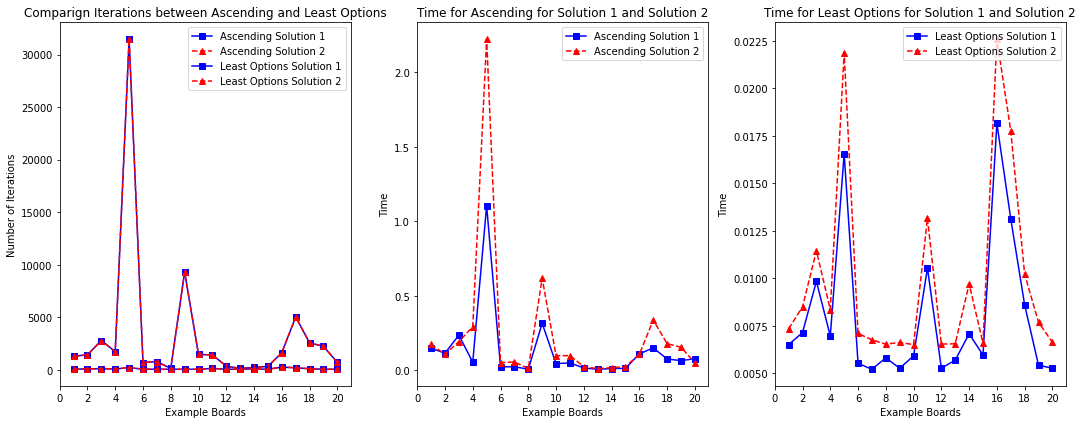

In [8]:
x = np.arange(1, len(iterations_ascending1)+1) # Example Boards

fig, axs = plt.subplots(1, 3, figsize=(15, 6)) # 2 subplots
# Subplot 1
axs[0].plot(x, iterations_ascending1 , color='blue', linestyle='-',  marker = "s", label='Ascending Solution 1')
axs[0].plot(x, iterations_ascending2, color='red', linestyle='--', marker = "^", label='Ascending Solution 2')
axs[0].plot(x, iterations_lo1 , color='blue', linestyle='-', marker = "s", label='Least Options Solution 1')
axs[0].plot(x, iterations_lo2, color='red', linestyle='--', marker = "^", label='Least Options Solution 2')
axs[0].set_xlabel('Example Boards')
axs[0].set_xticks(np.arange(0, 21,2))
axs[0].set_ylabel('Number of Iterations')
axs[0].set_title('Comparign Iterations between Ascending and Least Options')
axs[0].legend()

#Subplot 2

axs[1].plot(x, time_ascending1 , color='blue', linestyle='-',  marker = "s", label='Ascending Solution 1')
axs[1].plot(x, time_ascending2, color='red', linestyle='--', marker = "^", label='Ascending Solution 2')
axs[1].set_xlabel('Example Boards')
axs[1].set_xticks(np.arange(0, 21,2))
axs[1].set_ylabel('Time')
axs[1].set_title('Time for Ascending for Solution 1 and Solution 2')
axs[1].legend()

#Subplot 3

axs[2].plot(x, time_lo1 , color='blue', linestyle='-', marker = "s", label='Least Options Solution 1')
axs[2].plot(x, time_lo2, color='red', linestyle='--', marker = "^", label='Least Options Solution 2')
axs[2].set_xlabel('Example Boards')
axs[2].set_xticks(np.arange(0, 21,2))
axs[2].set_ylabel('Time')
axs[2].set_title('Time for Least Options for Solution 1 and Solution 2')
axs[2].legend()

plt.tight_layout()
plt.show()

The first thing we can see is that the approach where we choose the next cell to be the one that has the fewest options needs way fewer iterations and takes way less time than the approch where we go through the cells in ascending order. This makes sense because you will reach 'forcing positions' where a cell only has one candidate faster, so you can realise that you made a mistake and backtrack in fewer iterations.

We can see that Solutions 1 and 2 solve the puzzles in the same number of iterations and that Solution 2 is generally slower than solution 1. 

# Part 3: Algebra of Sudokus

In this section, we will explore different operations we can perform on completed Sudokus. Using these operations, we can define  morphs of Sudokus, and then an equivalence relation on the set of all Sudokus: two Sudokus $X$ and $Y$ are equivalent if there's a morph $f$ such that $Xf = Y$. We will present two different approaches of knowing if two sudokus are equivalent.

## Operations on Sudokus
There are operations we can do on completed Sudokus which will leave them as valid Sudokus. The four we will concentrate on are: 

1. Permuting rows in the same band.
2. Permuting columns in the same stack.
3. Tranposing.
4. Permuting the labels.

The first operation we will look at are row permutations in the same band. This is a function which takes two arguments: the Sudoku to be permuted, and a permutation. The permutation is given as a list of lists of length two, where `[i, j]` corresponds to swapping rows `i` and `j`. There is a check in the function to make sure that the two rows given in a list are in the same band, and if not, returns an error.


In [20]:
import numpy as np

def rowPerm(sudoku, rows):
    
    nSqrd = int(np.sqrt(len(sudoku)))
    
    # Turning sudoku into nSqrd x nSqrd array 
    sudoku = np.array(sudoku)
    sudoku = sudoku.reshape((nSqrd,nSqrd))
    
    for [row1,row2] in rows:
        # Checking that row1 and row2 are in the same band
        if abs(row1 - row2) > (np.sqrt(nSqrd-1)):
            print("Error: Rows provided are not in the same band.")
            return None
         
        # Switches row1 and row2
        sudoku[[row1,row2], :] = sudoku[[row2,row1], :]
    
    # Reshapes the array and returns the permuted sudoku as a list
    sudoku = sudoku.reshape((1,nSqrd**2))
    return sudoku.flatten().tolist()

Column permutations in the same stack work very similarily to row permutations in the same band, except now the elements in the list swap columns not rows.

In [21]:
def columnPerm(sudoku, columns):
    
    nSqrd = int(np.sqrt(len(sudoku)))
    
    # Turning sudoku into nSqrd x nSqrd array
    sudoku = np.array(sudoku)
    sudoku = sudoku.reshape((nSqrd,nSqrd))
    
    for [col1,col2] in columns:
        # Checking that col1 and col2 are in the same stack
        if abs(col1 - col2) > (np.sqrt(nSqrd)-1):
            print("Error: Columns provided are not in the same stack.")
            return None
    
        # Switches col1 and col2
        sudoku[:, [col1,col2]] = sudoku[:, [col2,col1]]
    
    # Reshapes the array and returns the permuted sudoku
    sudoku = sudoku.reshape((1,nSqrd**2))
    return sudoku.flatten().tolist()

Transposition is the third operation we present. This switches the $i,j$th entry in the Sudoku with the $j,i$th.

In [22]:
def transpose(sudoku):

    nSqrd = int(np.sqrt(len(sudoku)))
    
    # Turning sudoku into nSqrd x nSqrd array
    sudoku = np.array(sudoku)
    sudoku = sudoku.reshape((nSqrd, nSqrd))
    
    # Transposing
    sudoku = np.transpose(sudoku)
    
    # Reshapes the array and returns the transposed sudoku
    sudoku = sudoku.reshape((1,nSqrd**2))
    return sudoku.flatten().tolist()

def fastTranspose(sudoku): #Works around 5e-6 seconds faster for each normal (n=3) sudoku, but slower for n>10
    nSqrd = int(np.sqrt(len(sudoku)))

    # Transpose the 1D array
    transposedSudoku = [sudoku[j*nSqrd + i] for i in range(nSqrd) for j in range(nSqrd)]

    return transposedSudoku


Finally, the last operation we will show is permuting the values of the Sudoku. For an $n$-Sudoku, this is a permutation of the set $\{1,\ldots,n\}$.

In [23]:
def valuePerm(sudoku, f):
    
    #f is a permutation of the form [a_1, a_2, ..., a_(n^2)] such that
    #the digit i gets relabeled as a_(i-1), for example:
    #   1 -> a_1,    2 -> a_2,    n^2 -> a_(n^2)

    nSqrd = int(np.sqrt(len(sudoku)))
    
    # Turning sudoku into nSqrd x nSqrd array 
    sudoku = np.array(sudoku)
    sudoku = sudoku.reshape((nSqrd,nSqrd))
    
    #Defines a function to apply the permutation f to a single digit x
    def applyPerm(x): 
        return f[x-1]
    
    #Vectorise the above function so it can be applied to the sudoku
    vectApplyPerm = np.vectorize(applyPerm)
    
    #Apply permutation to entire grid
    return(vectApplyPerm(sudoku).reshape(nSqrd*nSqrd) )

def fastValuePerm(sudoku, f):#faster for n<10
    
    #f is a permutation of the form [a_1, a_2, ..., a_(n^2)] such that
    #the digit i gets relabeled as a_(i-1), for example:
    #   1 -> a_1,    2 -> a_2,    n^2 -> a_(n^2)

    #Applies permutation to the digits
    permutedSudoku = [f[x-1] for x in sudoku]

    return permutedSudoku

Next, we will define a morph. We say that two Sudokus $X$ and $Y$ are morphs if there is a sequence of row permutations, column permutations, tranpositions, and value permutations such that applying $X$ to these operations will give result in $Y$. It can be shown that any morph can be represented by first applying row permutations, then column permutations, then tranpositions, and finally value permutations. This creates a natural equivalence relation on the set of $n$-Sudokus: $X \sim Y$ if $Y$ is a morph of $X$.

## Determining if two Sudokus are equivalent

A natural question to ask is if there's a way to know if two Sudokus are equivalent. We will present two ways which are very different from one another. One way uses canonisation while the other uses a more group theoretic approach. These are both valid options to determine if two Sudokus are equivalent but their complexities vary wildly.

### Canonisation

The motivation for canonisation is to find a process of operations under which two Sudokus in the same equivalence class are _reduced_ to the same _elementary_ Sudoku. We will refer to these elementary sudokus as the _leader_ of its respective equivalence class under the operations above.

When studying Latin Squares (LS), we say two LS are _isotopic_ if one can be converted to the other under the following operations:
1. permuting the rows
2. permuting the columns
3. permuting the symbols

A canonisation algorithm follows intuitively by trying to achieve a _minimal_ form, for example permute the rows and columns such that the first row is $[1,2,\dots,n^{2}]$ and the first column is $[1,2,\dots,n^{2}]^{T}$. Then every pair of isotopic LS will become the same minimal LS under this algorithm and the shared minimal LS is the leader of the equivalence class.

It is clear that a canonisation algorithm for Sudokus must work similarly, in that we must force the Sudoku to have a very specific form via the morphing operations. One such method is as follows:
1. Fix a digit $i$.
2. Apply row and column permutations within bands such that the placement of i has rotational symmetry.
3. Choose one block and relabel such that i stays in the same position and the remaining digits are in ascending order.

An example of this algorithm in use can be seen below (dashes are only in place to see the pattern of i more clearly):

```
Original Sudoku, S                 S under 1 -> 3 with i = 3          S under 1 -> 3 with i = 7

3 1 6 | 5 7 8 | 4 9 2              - - - | - - - | 3 - -              - - - | - - - | 7 - -
5 2 9 | 1 3 4 | 7 6 8              - - - | 3 - - | - - -              - - - | 7 - - | - - -
4 8 7 | 6 2 9 | 5 3 1              3 - - | - - - | - - -              7 - - | - - - | - - -
---------------------              ---------------------              ---------------------
2 6 3 | 4 1 5 | 9 8 7              - - - | 1 2 4 | - 3 -              - - - | 1 2 3 | - 7 -
9 7 4 | 8 6 3 | 1 2 5              - - - | 5 3 6 | - - -              - - - | 4 7 5 | - - -
8 5 1 | 7 9 2 | 6 4 3              - 3 - | 7 8 9 | - - -              - 7 - | 6 8 9 | - - -
---------------------              ---------------------              ---------------------
1 3 8 | 9 4 7 | 2 5 6              - - - | - - - | - - 3              - - - | - - - | - - 7
6 9 2 | 3 5 1 | 8 7 4              - - - | - - 3 | - - -              - - - | - - 7 | - - -
7 4 5 | 2 8 6 | 3 1 9              - - 3 | - - - | - - -              - - 7 | - - - | - - -
```

We now refer to this algorithm as the transformation $f_{i}$. Since $f_{i}$ forces every Sudoku into a very restrictive form using relabelling and row/column permutations, if $S$ and $T$ are morphs of each other then one of the following will hold:
1. $Sf_{i} = Tf_{i}$ for some $i \in {1,2,\dots,n^{2}}$
2. $S^{T}f_{i} = Tf_{i}$ for some $i \in {1,2,\dots,n^{2}}$

In fact, the rotational symmetry of the pattern of $i$ ensures that the algorithm works for sudokus morphed via rotations of 90, 180 and 270 degrees.

First we begin with some helper functions which: find the correct permutation to relabel the values given a start and target array and return the nxn block of a sudoku starting from any square:


In [24]:
def findPerm(originalList, targetList):
    n = len(originalList)
    perm = [0]*n
    for i in range(n):
        perm[i] = targetList[originalList.index(i+1)]
    return perm

def getBlock(sudoku, row, col, n):
    nSqrd = int(np.sqrt(len(sudoku)))
                
    #Create 2D version of sudoku
    sudoku2D = np.array(sudoku).reshape(nSqrd, nSqrd)
    
    #Get nxn block with top left corner at (row, col)
    block = []
    for i in range(n):
        block.append(sudoku2D[row + i][col:col+n])
    block1D = [elt for row in block for elt in row]
    return block1D

Now we implement our canonisation algorithm for a single sudoku grid:


In [25]:
def canonise3x3(sudoku, digit):#Canonise sudoku grid
    nSqrd = int(np.sqrt(len(sudoku)))
    
    #Perform row and column swaps within bands to rearrange digit into specified pattern
    for i in range(3):
        for j in range(3):
            block = getBlock(sudoku, 3*i, 3*j, 3) #1D representation of the block (i,j) where 0<=i,j<=2
            ptLoc = block.index(digit) #index of desired digit within block
            x, y = ptLoc // 3, ptLoc % 3 #convert 1D index to 2D index - (x, y) is (row, col) within the block
            sudoku = rowPerm(sudoku, [[3*i + x, 3*i + 2-j]])#Swap rows such that value forms a pattern of rotational symmetry
            sudoku = columnPerm(sudoku, [[3*j + y, 3*j + i]])
    
    #Get list in sorted order, except digit remains in place
    newMiddleCell = [i+1 for i in range(0, 9) if i+1 != digit]
    newMiddleCell.insert(4, digit)
    #newMiddleCell = [1,2,3,4,5,6,7,8,9]
    
    #Get current middle block of the sudoku
    middleCell = getBlock(sudoku, 3, 3, 3)
    
    #Get permutation that takes current middle block to desired middle block
    perm = findPerm(middleCell, newMiddleCell)
    
    #Apply permutation to the sudoku
    sudoku = fastValuePerm(sudoku, perm)
    return(sudoku)

Then we just need to check each possible canonisation of a sudoku with different parameters:

In [26]:
def arrToInt(array):
    #Returns array of integers as the one integer lexically
    return int(''.join(map(str, array)))

def canonFirstRow(sudoku, i):
    #Returns first row of canonised Sudoku as an integer
    return arrToInt(canonise3x3(sudoku, i+1)[0:9])

def isMorph3x3(sudoku1, sudoku2):
    #Iterate canonisation through every possible i
    n = len(sudoku1)
    if n != len(sudoku2): raise ValueError("Both sudokus must have same length")
    if (np.sqrt(np.sqrt(n))//1)**4 != n: raise ValueError("Sudoku length must be a power of four")
    nSqrd = int(np.sqrt(n))
    if max(sudoku1) > nSqrd or max(sudoku2) > nSqrd: raise ValueError("Sudoku values cannot exceed n^2")
    if min(sudoku1) < 1 or min(sudoku2) < 1: raise ValueError("Sudoku values must be >= 1")        
            
    firstRowS1, firstRowS1T, firstRowS2 = [],[],[]
    for i in range(9):
        #Get the first row of sudoku1, sudoku1^T and sudoku2 after canonisation
        firstRowS1.append(canonFirstRow(sudoku1, i))
        firstRowS1T.append(canonFirstRow(transpose(sudoku1), i))
        firstRowS2.append(canonFirstRow(sudoku2, i))
    for i in range(9):
        for j in range(9):
            if firstRowS1[i] == firstRowS2[j] or firstRowS1T[i] == firstRowS2[j]:
                return True
    return False

It is important to note that if a sudoku is an automorphism (i.e. it can be morphed into itself via non-trivial transformations) then this algorithm may not work and would require a function that can detect if a sudoku is an automorphism. However, a process that doesn't rely on non-automorphic sudokus is the following.

### A group theoretic approach

We know that a $n$-Sudoku morph can be represented by a row permutation, a column permutation, a transposition, and then a permutation of the values. Using this knowledge, we can represent a morph of a $n$-Sudoku as a group.

If we label the bands of a $n$-Sudoku as $A_1,\ldots,A_n$, then a row permutation is a permutation of the rows in each $A_i$ ($1 \leq i \leq n$). Each band has $n$ rows, so every permutation of the rows in a band is an element of the symmetric group of order $n!$, $S_n$. As a permutation of rows in a band does not interfere with any rows in a different band, we can write a row permutation as a sequence of $n$ elements from $S_n$. The set of all sequences of  elements from $S_n$ of length $n$ is the group $(S_n)^n$, the direct product of $n$ copies of $S_n$. A similar argument can be made with column permutations. 

Given a Sudoku $S$, we have two decisions; we can tranpose the Sudoku, or we can leave it as is. If we transpose $S$ twice, we are left with $S$ again. This behaviour can be represented by the cyclic group of order $2$, $C_2$.

Finally, a permutation of values of a $n$-Sudoku can be represented by a permutation in $S_(n^2)$. Putting this all together, we can represent a morph of an $n$-Sudoku by a sequence $(\pi, \tau, z, \sigma)$ where $\pi, \tau \in (S_n)^n$, $z \in C_2$, and $\sigma \in  S_{n^2}$. The set of all of these sequences is the direct product $$(S_n)^n \times (S_n)^n \times C_2 \times S_{n^2}.$$ This group has order $(n!)^n \times (n!)^n \times 2 \times (n^2)! = 2(n!)^{2n}(n^2)!$. From now on, we will refer to the group $(S_n)^n \times (S_n)^n \times C_2 \times S_{n^2}$ as $G$.

Let $X$ be the set of all Sudokus. Then $G$ acts on $X$ in the natural way. Determining if two Sudokus are morphs of each other is equivalent to asking if two Sudokus lie in the same orbit. We could calculate this orbit directly using $G$, but we'll run into difficulty as $G$ is so big. Therefore, given two $n$-Sudokus $S,T$, our strategy will be only considering when $n=3$, calculating the orbit of $S$ under $(S_n)^n \times (S_n)^n \times C_2$. Notice we're not considering value permutations as these take a very long time to compute.

In [27]:
# These are all possible permutations of each block/stack
S3b1 = [[[0,0]], [[0,1]], [[0,2]], [[1,2]], [[0,1],[0,2]], [[0,2],[0,1]]]
S3b2 = [[[3,3]], [[3,4]], [[3,5]], [[4,5]], [[3,4],[3,5]], [[3,5],[3,4]]]
S3b3 = [[[6,6]], [[6,7]], [[6,8]], [[7,8]], [[6,7],[6,8]], [[6,8],[6,7]]]

# This gives a list of all possible row/column permutations
permutations = []
for i in S3b1:
    for j in S3b2:
        for k in S3b3:
            permutations.append(i+j+k)

# This function will return all Sudokus in the "restricted" orbit (not considering value permutations)
def restrictedOrbit(sudoku):
    
    # There are 216 possible row permutations
    fullGrid = [sudoku]*216
    
    # This will be the list of all Sudokus under all row permutations
    rowPermuted = [] 
    
    # Performs the row permutations and adds is to rowPermuted
    for i in range(216):
        tempSudoku = rowPerm(fullGrid[i], permutations[i])
        rowPermuted.append(tempSudoku)
    
    # columnPermuted[i] will be rowPermuted after being columnPermuted by permutations[i]
    columnPermuted = [[] for _ in range(216)]

    # Similar to rowPermuted
    for s in range(0,216):
        for t in range(0,216):
            tempSudoku = columnPerm(rowPermuted[t], permutations[s])
            columnPermuted[s].append(tempSudoku)
    
    # This will be the list of Sudokus found so far, transposed
    transposed = [[] for _ in range(216)]
    
    # Performs the transposition
    for i in range(0,216):
        for j in range(0,216):
            tempSudoku = transpose(columnPermuted[i][j])
            transposed[i].append(tempSudoku)
    
    # Combines the lists of transposed and nottransposed Sudokus
    restrictedMorphs = columnPermuted + transposed
    
    return restrictedMorphs

The reason the list `restricedMorphs` is in this strange format is because the data of what row permutation, column permutation, and whether a transposition was performed, is preserved. Note that this list might have repeated Sudokus.

We can now define a function which determines if two $3$-Sudokus are in the same restricted orbit, and if so, gives the morph between them in the format `[True, rowPerm, columnPerm, transposition]`.

In [28]:
# This will return a True along with the morph (so we can calc. the morph which sends s1 to s2)
# if the Sudokus are morphs, and False otherwise
def restrictedEquiv(sudoku1, sudoku2):
    orbit = restrictedOrbit(sudoku1)
    
    for i in orbit:
        for j in i:
            if j == sudoku2:
                # if orbit.index(i) is above 216, then the Sudoku is in the half of orbit added when we were
                # considering tranpositions in restritedOrbit
                if orbit.index(i) > 216: 
                    return [True, permutations[i.index(j)], permutations[(orbit.index(i))-216], 1]
                else:
                    return [True, permutations[i.index(j)], permutations[orbit.index(i)], 0]
    return False

Using this restricted orbit, we can get a bound on the stabiliser of a Sudoku. To do this we need to trim down the list `restrictedOrbit` since it might have repeats.

In [29]:
# Returns a list of distinct elements in the orbit
def distinctResOrbit(sudoku):
    orbit = restrictedOrbit(sudoku)
    
    distinctOrbit = []
    
    for i in orbit:
        for j in i:
            if j not in distinctOrbit:
                distinctOrbit.append(j)
    
    return distinctOrbit

Using this new orbit, we can get a bound on the stabiliser of a Sudoku. Let $S$ be a Sudoku. We'll denote the orbit of $S$ by $\textrm{Orb}(S)$ and the stabiliser by $\textrm{Stab}(S)$. By the Orbit-Stabiliser theorem, we know that $$|\textrm{Stab}(S)| = \frac{|G|}{|\textrm{Orb}(S)|}.$$ Hence, as we're *underestimating* the orbit of $S$ by not considering value permutations, we know that $$|\textrm{Stab}(S)| \leq \frac{|G|}{|\textrm{Orb}(S)|}.$$ If we take $G$ to be the group $(S_3)^3 \times (S_3)^3 \times C_2$ (which we will now denote as $H$) however, ignoring value permutations, then this is an equality.

In [30]:
# This returns a bound on the size of the stabiliser of a Sudoku
def boundOnStab(sudoku):
    distinctOrbit = distinctResOrbit(sudoku)
    orbSize = len(distinctOrbit)
    
    # big num. is the order of G when n=3
    return (33861058560)/orbSize

It's worth noting that the code above isn't efficient. The canonisation method is far faster, but doesn't give any information on orbits, stabilisers, and if two Sudokus are equivalent (without a value permutation) what is the morph taking one to the other.

### Testing and examples

Here is a $3$-Sudoku. 

In [31]:
testSudoku = [4,3,5,2,6,9,7,8,1,6,8,2,5,7,1,4,9,3,1,9,7,8,3,4,5,6,2,8,2,6,1,9,5,3,4,7,3,7,4,6,8,2,9,1,5,9,5,1,7,4,3,6,2,8,5,1,9,3,2,6,8,7,4,2,4,8,9,5,7,1,3,6,7,6,3,4,1,8,2,5,9]

We will do a morph on this Sudoku to give evidence that our functions work and how their output will look like.

In [32]:
testSudokuPermuted = columnPerm(rowPerm(testSudoku, [[4,5],[0,2],[6,7]]), [[1,2]])

# This should return True, along with the morph between them
print(restrictedEquiv(testSudoku, testSudokuPermuted))

# This should return the same as above but with a 1 in the last position in the list indicating a transpose
print(restrictedEquiv(testSudoku, transpose(testSudokuPermuted)))

fakeSudoku = [x for x in range(9)]*9

# This should return False as fakeSudoku isn't even a Sudoku
print(restrictedEquiv(testSudoku, fakeSudoku))

[True, [[0, 2], [4, 5], [6, 7]], [[1, 2], [3, 3], [6, 6]], 0]
[True, [[0, 2], [4, 5], [6, 7]], [[1, 2], [3, 3], [6, 6]], 1]
False


### Closing remarks on the group theoretic approach

I was excited to use group theory to solve this part of the project since is uses algebra, a part of mathematics I'm passionate about. I'm glad I was able to inclu

It is important to note that if a sudoku is an automorphism (i.e. it can be morphed into itself via non-trivial transformations) then this algorithm may not work and would require a function that can detect if a sudoku is an automorphism. However, a process that doesn't rely on non-automorphic sudokus is the following.

### A group theoretic approach

We know that a $n$-Sudoku morph can be represented by a row permutation, a column permutation, a transposition, and then a permutation of the values. Using this knowledge, we can represent a morph of a $n$-Sudoku as a group.

If we label the bands of a $n$-Sudoku as $A_1,\ldots,A_n$, then a row permutation is a permutation of the rows in each $A_i$ ($1 \leq i \leq n$). Each band has $n$ rows, so every permutation of the rows in a band is an element of the symmetric group of order $n!$, $S_n$. As a permutation of rows in a band does not interfere with any rows in a different band, we can write a row permutation as a sequence of $n$ elements from $S_n$. The set of all sequences of  elements from $S_n$ of length $n$ is the group $(S_n)^n$, the direct product of $n$ copies of $S_n$. A similar argument can be made with column permutations. 

Given a Sudoku $S$, we have two decisions; we can tranpose the Sudoku, or we can leave it as is. If we transpose $S$ twice, we are left with $S$ again. This behaviour can be represented by the cyclic group of order $2$, $C_2$.

Finally, a permutation of values of a $n$-Sudoku can be represented by a permutation in $S_(n^2)$. Putting this all together, we can represent a morph of an $n$-Sudoku by a sequence $(\pi, \tau, z, \sigma)$ where $\pi, \tau \in (S_n)^n$, $z \in C_2$, and $\sigma \in  S_{n^2}$. The set of all of these sequences is the direct product $$(S_n)^n \times (S_n)^n \times C_2 \times S_{n^2}.$$ This group has order $(n!)^n \times (n!)^n \times 2 \times (n^2)! = 2(n!)^{2n}(n^2)!$. From now on, we will refer to the group $(S_n)^n \times (S_n)^n \times C_2 \times S_{n^2}$ as $G$.

Let $X$ be the set of all Sudokus. Then $G$ acts on $X$ in the natural way. Determining if two Sudokus are morphs of each other is equivalent to asking if two Sudokus lie in the same orbit. We could calculate this orbit directly using $G$, but we'll run into difficulty as $G$ is so big. Therefore, given two $n$-Sudokus $S,T$, our strategy will be only considering when $n=3$, calculating the orbit of $S$ under $(S_n)^n \times (S_n)^n \times C_2$. Notice we're not considering value permutations as these take a very long time to compute.

In [33]:
# These are all possible permutations of each block/stack
S3b1 = [[[0,0]], [[0,1]], [[0,2]], [[1,2]], [[0,1],[0,2]], [[0,2],[0,1]]]
S3b2 = [[[3,3]], [[3,4]], [[3,5]], [[4,5]], [[3,4],[3,5]], [[3,5],[3,4]]]
S3b3 = [[[6,6]], [[6,7]], [[6,8]], [[7,8]], [[6,7],[6,8]], [[6,8],[6,7]]]

# This gives a list of all possible row/column permutations
permutations = []
for i in S3b1:
    for j in S3b2:
        for k in S3b3:
            permutations.append(i+j+k)

# This function will return all Sudokus in the "restricted" orbit (not considering value permutations)
def restrictedOrbit(sudoku):
    
    # There are 216 possible row permutations
    fullGrid = [sudoku]*216
    
    # This will be the list of all Sudokus under all row permutations
    rowPermuted = [] 
    
    # Performs the row permutations and adds is to rowPermuted
    for i in range(216):
        tempSudoku = rowPerm(fullGrid[i], permutations[i])
        rowPermuted.append(tempSudoku)
    
    # columnPermuted[i] will be rowPermuted after being columnPermuted by permutations[i]
    columnPermuted = [[] for _ in range(216)]

    # Similar to rowPermuted
    for s in range(0,216):
        for t in range(0,216):
            tempSudoku = columnPerm(rowPermuted[t], permutations[s])
            columnPermuted[s].append(tempSudoku)
    
    # This will be the list of Sudokus found so far, transposed
    transposed = [[] for _ in range(216)]
    
    # Performs the transposition
    for i in range(0,216):
        for j in range(0,216):
            tempSudoku = transpose(columnPermuted[i][j])
            transposed[i].append(tempSudoku)
    
    # Combines the lists of transposed and nottransposed Sudokus
    restrictedMorphs = columnPermuted + transposed
    
    return restrictedMorphs

The reason the list `restricedMorphs` is in this strange format is because the data of what row permutation, column permutation, and whether a transposition was performed, is preserved. Note that this list might have repeated Sudokus.

We can now define a function which determines if two $3$-Sudokus are in the same restricted orbit, and if so, gives the morph between them in the format `[True, rowPerm, columnPerm, transposition]`.

In [34]:
# This will return a True along with the morph (so we can calc. the morph which sends s1 to s2)
# if the Sudokus are morphs, and False otherwise
def restrictedEquiv(sudoku1, sudoku2):
    orbit = restrictedOrbit(sudoku1)
    
    for i in orbit:
        for j in i:
            if j == sudoku2:
                # if orbit.index(i) is above 216, then the Sudoku is in the half of orbit added when we were
                # considering tranpositions in restritedOrbit
                if orbit.index(i) > 216: 
                    return [True, permutations[i.index(j)], permutations[(orbit.index(i))-216], 1]
                else:
                    return [True, permutations[i.index(j)], permutations[orbit.index(i)], 0]
    return False

Using this restricted orbit, we can get a bound on the stabiliser of a Sudoku. To do this we need to trim down the list `restrictedOrbit` since it might have repeats.

In [35]:
# Returns a list of distinct elements in the orbit
def distinctResOrbit(sudoku):
    orbit = restrictedOrbit(sudoku)
    
    distinctOrbit = []
    
    for i in orbit:
        for j in i:
            if j not in distinctOrbit:
                distinctOrbit.append(j)
    
    return distinctOrbit

Using this new orbit, we can get a bound on the stabiliser of a Sudoku. Let $S$ be a Sudoku. We'll denote the orbit of $S$ by $\textrm{Orb}(S)$ and the stabiliser by $\textrm{Stab}(S)$. By the Orbit-Stabiliser theorem, we know that $$|\textrm{Stab}(S)| = \frac{|G|}{|\textrm{Orb}(S)|}.$$ Hence, as we're *underestimating* the orbit of $S$ by not considering value permutations, we know that $$|\textrm{Stab}(S)| \leq \frac{|G|}{|\textrm{Orb}(S)|}.$$ If we take $G$ to be the group $(S_3)^3 \times (S_3)^3 \times C_2$ (which we will now denote as $H$) however, ignoring value permutations, then this is an equality.

In [36]:
# This returns a bound on the size of the stabiliser of a Sudoku
def boundOnStab(sudoku):
    distinctOrbit = distinctResOrbit(sudoku)
    orbSize = len(distinctOrbit)
    
    # big num. is the order of G when n=3
    return (33861058560)/orbSize

It's worth noting that the code above isn't efficient. The canonisation method is far faster, but doesn't give any information on orbits, stabilisers, and if two Sudokus are equivalent (without a value permutation) what is the morph taking one to the other.

### Testing and examples

Here is a $3$-Sudoku. 

In [37]:
testSudoku = [4,3,5,2,6,9,7,8,1,6,8,2,5,7,1,4,9,3,1,9,7,8,3,4,5,6,2,8,2,6,1,9,5,3,4,7,3,7,4,6,8,2,9,1,5,9,5,1,7,4,3,6,2,8,5,1,9,3,2,6,8,7,4,2,4,8,9,5,7,1,3,6,7,6,3,4,1,8,2,5,9]

We will do a morph on this Sudoku to give evidence that our functions work and how their output will look like.

In [38]:
testSudokuPermuted = columnPerm(rowPerm(testSudoku, [[4,5],[0,2],[6,7]]), [[1,2]])

# This should return True, along with the morph between them
print(restrictedEquiv(testSudoku, testSudokuPermuted))

# This should return the same as above but with a 1 in the last position in the list indicating a transpose
print(restrictedEquiv(testSudoku, transpose(testSudokuPermuted)))

fakeSudoku = [x for x in range(9)]*9

# This should return False as fakeSudoku isn't even a Sudoku
print(restrictedEquiv(testSudoku, fakeSudoku))

[True, [[0, 2], [4, 5], [6, 7]], [[1, 2], [3, 3], [6, 6]], 0]
[True, [[0, 2], [4, 5], [6, 7]], [[1, 2], [3, 3], [6, 6]], 1]
False


### Some final comments on the group theoretic approach

I was enthusiastic with writing this part of the project since it was algebra-like. Unfortunately, the group theoretic approach might not be the best way to tackle the problem as the computations you end up having to do become enormous. It would've been nice to incorporate some more results into the analysis, like Burnside's Lemma to calculate the number of orbits. I am happy with my code of determining of two Sudokus are in the same orbit and what morph maps one to another, but I am less confident with my code on determining bounds.

## Why a $n$-Sudoku puzzle can't have a unique solution if it contains fewer than $n^2-1$ entries

If a $n$-Sudoku puzzle has less than $n^2-1$ entries, then there are at least $2$ numbers in the set $\{1,\ldots,n^2\}$ which haven't been put in the puzzle at all, say $x$ and $y$. This means, if we solve the puzzle, we can value permute the Sudoku with the permutation which maps $x$ to $y$, $y$ to $x$, and leaves the others numbers unchanged. This value permutation gives a different solution to the puzzle.

# Part 4: Application of Manual Sudoku Techniques

(BY NIHARIKA CHAVAN) 

In the previous parts, we have explored methods to solve partially completed $n \times n$ sudoku grids by using basic backtracking methods to restrict candidate cell values. However, especially for large $n$, this can be computationally expensive and time consuming.

To reduce computation efforts, we can use algorithms that restrict the candidate cell values before backtracking. If the Sudoku puzzle is not solved after this restriction, then we can employ backtracking methods. This way, even if backtracking is used, the algorithm is sifting through a reduced number of candidate cell values for each unsolved cell and is computationally efficient than backtracking alone.

In this part, we shall employ the following two techniques:

1. If there is only one candidate value for a cell, then assign the cell that value 
    
2. If there is only one cell within a row, column, or box that has a value $z$ as a candidate, then assign the cell the value $z$.

In Solution 1, `reduction(S, candidate_list_S)` implements technique 1 and `elimination(S, candidate_list_S)` implements technique 2.


The strategy we used for this question is to independently write and implement two different functions that use the above techniques, and then evaluate which of our methods is more efficient by timing the functions. The most efficient functions will then be used for the backtracking process.

Before considering any computation, we must have examples of partially filled sudoku grids that are accessible for any testing. This has been achieved, not only by considering the examples provided, but also by considering simple $2 \times 2$ cases which we shall to check the functions defined subsequently are operating as intended.



In [39]:
## EXAMPLE SUDOKU GRIDS
import gzip
import pickle
with gzip.open("4x4-puzzle.tar.gz", "rb") as f:
    large_puzzle = pickle.load(f)
with gzip.open("unique-3x3.tar.gz", "rb") as g:
    unique_3x3 = pickle.load(g)

In [40]:
## SIMPLE 2X2 EXAMPLES FOR TESTING
Correct = [1,2,3,4,3,4,1,2,2,1,4,3,4,3,2,1]    
N = [0,2,3,4,3,0,1,2,2,1,4,0,4,3,0,1]
M = [0,2,3,0,3,0,1,2,0,1,4,0,0,3,0,1]

## Solution 1

In this solution, my objective is to provide a general optimised function that employs both manual techniques 1 and 2, which can then undergo backtracking if need be to solve the puzzle.

My initial aim is to produce two functions `reduction(S, candidate_list_S)` and `elimination(S, candidate_list_S)` corresponding to techniques 1 and 2 respectively, which inputs the partially completed Sudoku list `S` and either outputs a completed solution for `S`, or a list containing the set of possible candidate values for each of the cells in `S`.

(If we have already computed a list of reduced candidate values for each cell, then to improve efficiency I have added a second input `candidate_list(S)` to both functions.)

Furthermore, by combining `reduction` and `elimination` into one neater function that I have called `combined`, I intend to iterate our `candidate_list_S` through `combined`, until either `S` has been solved, or `candidate_list_S` can no longer be reduced. Once I have achieved this, `candidate_list_S` will be in the most optimised form and can be backtracked to solve `S`.

### Cell Locator Functions

For the reduction and elimination methods, I will need to retrieve information regarding the location of each of the unsolved cells $x$, in order to determine which other cells are in the same row, column or box as $x$ (for future reference, I will refer to any cells $y$ that are in the same row, column or box as $x$ as being in the same neighbourhood as $x$. If any of these cells $y$ are filled in, then we can eliminate the values `S[y]` from the set of possible candidate values that x can take.

For the elimination method, I will need to know whether $x$ and $y$ are specifically in the same row, same column or same box as each other in order to satsify the condition for technique 2. This is obtained by applying either `row_set(S,x)`, `col_set(S,x)` or `box_set(S,x)` respectively.

However, for the reduction method, I only need to know whether or not $y$ is in the same neighbourhood as $x$ (since if `S[y] != 0`, $x$ cannot have the value `S[y]`). The `search(S,x)` outputs the set of all $y$ in the same neighbourhood as $x$.

In [41]:
## All the functions are used for the elimination method
## All functions except row_set, col_set and box_set are used for the reduction method

## Since I will be using the value of n squared a lot in the subsequent functions, I have defined a new function that will return n squared, to avoid having to redefine this value every time
def n_sq(S):
    return int(len(S)**(0.5))

## For a given cell index, this returns the ...

# ... row number
def row(S,x): 
    return x // n_sq(S)

# ... column number
def column(S,x):
    return x % n_sq(S)

# ... box number
def box(S,x):
    r = row(S,x)
    c = column(S,x)
    n = int(n_sq(S)**0.5)
    return r - r%n + c // n

#-----------------------------------------------------------------------------------------------------------------------------------------
## For a given cell index x, if we want to obtain the other indices which are in the same row, column or box as x, WITHOUT containing x
def row_set(S,x):
    r_set = set()
    for y in range(len(S)):
        if row(S,y) == row(S,x) and y != x:
            r_set.add(y)
    return r_set

def col_set(S,x):
    c_set = set()
    for y in range(len(S)):
        if column(S,y) == column(S,x) and y != x:
            c_set.add(y)
    return c_set

def box_set(S,x):
    b_set = set()
    for y in range(len(S)):
        if box(S,y) == box(S,x) and y != x:
            b_set.add(y)
    return b_set

#----------------------------------------------------------------------------------------------------------------------------------------
## This function returns the set containing all indices y that are either in the same row or column as x WITHOUT including x itself
def search(S,x):
    return row_set(S,x) | col_set(S,x)| box_set(S,x)

In [42]:
## This function is purely reformat the Sudoku list into a square format to make this more readable, but is not necessary
def sudoku_format(S):
    size =  len(S)
    result = []
    for i in range(0, size, n_sq(S)):
        result.append(S[i:i+n_sq(S)])
    return result

In [43]:
## This function obtains the list of unsolved cells for a partially completed Sudoku
## Create and initialise a list one containing all the cell indices that are unsolved in the partially completed Sudoku
    
def unsolved_cells(S):
    unsolved = {i for i in range(len(S)) if S[i] == 0}
    return unsolved

In [44]:
## TEST CELL
unsolved_cells(N)

{0, 5, 11, 14}

### Introducing the Candidate Store

In the functions below, for each unsolved cell with index $x$, I have defined the set `candidates` to contain the possible candidate values for the cell $x$.

When employing the reduction and elimination techniques, I wanted to have a list that 'retained memory' of the remaining candidate values for each $x$ after reducing the number of values in `candidates`.

To do this, I have introduced the concept of the `candidate_store`, which is a list with the same length as the partially filled Sudoku `S` and `candidate_store[x] = candidates`.

For any cell with index $a$ that has already been solved, there can only be candidate value for $a$, which is `S[a]`. And so `candidate_store = {S[a]}`.

By doing this, I can retrieve the set of possible candidate values for any unsolved cell and pass this list for subsequent reduction or elimination.

### Initialising the Candidate Store

Let $n$ be the quartic root of the length of the length of the Sudoku grid (as defined in the `box(S,x)` function). I will refer to this $n$ as the "dimension" of the Sudoku grid.

Without doing any elimination or reduction, we know that any unsolved cell with index $x$ must take a value between 1 and $n^2$ inclusive, by the rules of Sudoku. On the other hand, any solved cell with index $a$ must have one candidate value, `S[a]` as specified earlier.

Using this information, we can set up an initial `candidate_store` list.

In [45]:
## In the first iteration of reduction_technique(S) we want to initialise the candidate_store and unsolved_entries.
def initialise(S):
     
    ## Assign variables "size" and "n" for simplification
    size = len(S)
    n = int(size**0.25)
    
    unsolved = unsolved_cells(S)
    
    candidate_store = [0]*size
    
    ## If we know that a cell has already been filled in with the value m, there should only be one candidate value for the cell - {m}
    ## Otherwise, before doing any processing the cell could have any value between 1 to n^2
    for i in range(size):
        if i in unsolved:
            candidate_store[i] = {*range(1, n**2+1)}
        else:
            candidate_store[i] = {S[i]}
            
    return candidate_store

In [46]:
print(initialise(N))

[{1, 2, 3, 4}, {2}, {3}, {4}, {3}, {1, 2, 3, 4}, {1}, {2}, {2}, {1}, {4}, {1, 2, 3, 4}, {4}, {3}, {1, 2, 3, 4}, {1}]


### Reduction Technique

This function will solve the Sudoku using this technique - "If there is only one candidate value for a cell, then assign the cell that value."

With the partially filled Sudoku grid `S` and the `candidate_list_S` of S, the function retrieves the unsolved indices in `S` by using the `unsolved_cells(S)` function.

(Note, the variable I have called `candidate_list_S` is the `candidate_store` output after returning either `initialise`, `reduction` or `elimination`. But, I wanted to keep the variable `candidate_store` as something that is only defined within a given function.)

Then I have reduced the possible candidate values for the cell `S[x]` by looking at any indices $j$ in the same row, column or box as $x$ and creating a set containing all of these `S[j]` values. Next, I have discarded all of these possible `S[j]` from the existing set of candidates, `candidate_store[x]`.

If at this point `S[x]` has been reduced down to one candidate value $k$ then `S[x] = k` and we have solved for the index $x$.

I have also created a new set called `now_solved` that will contain all of the indices have been solved through this iteration of the `reduction` function. All of these newly solved indices are removed from `unsolved` after iterating through all $x$. I opted for this method rather than removing the index from `unsolved` whilst iterating through $x$ because this would output errors due to set alteration when iterating.

Finally, if there are no more unsolved cells then the function returns a completed Sudoku grid. Otherwise, the output is an updated list of candidates

In [47]:
def reduction(S, candidate_list_S):
    
    ## We will retrieve this list of potential candidate values, which will either come from previous iterations of the reduction function, or the base case when we we use the initialise function
    ## The idea is that the ith zero in the candidate_store will contain the potential (candidate) values for the ith cell in the Sudoku (which should be unfilled)
    
    candidate_store = candidate_list_S
    
    ## Assign variables "size"
    size = len(S)
   
    unsolved = unsolved_cells(S)
    
    ## Create an empty set that will contain the indices of all the cells that have been solved by applying the reduction function
    now_solved = set()
    ## For each unsolved index, create a set containing all of the S[j] that have been filled in - it doesn't matter here that 0 will also be in this set
    for x in unsolved:

        #candidates = candidate_store[x]
        to_remove = {S[j] for j in search(S,x)} 
        
        ## Remove all of the filled in values (contained in to_remove) from the set of potential candidates
        candidates = candidate_store[x] - to_remove
        
        ## If there is only one candidate value j left in the cell then we must have that the xth cell must have this candidate value. Hence we have solved S[k] 
        if len(candidates) == 1:
            for k in candidates:
                S[x] = k
            now_solved.add(x)
        
        candidate_store[x] = candidates
    
        ## Remove any newly solved indices from the unsolved set
        unsolved = unsolved - now_solved
        
    ## Break statement - if after iterating through we have no unsolved cells left then the Sudoku is solved
    if not unsolved:
        return S
    
    ## If there are still some unsolved cells, this will output a list containing the updated candidate sets for each cell (including those filled in, as described in line 13) ready for further iterations
    else:
        return candidate_store
    
## Note, whilst S may still be unsolved, if any cells have been solved in one iteration of the function then S has still been altered

#### The subsequent cells are for checking the `reduction` function on various examples

In [48]:
N1 = N.copy()
reduction(N1, initialise(N))
## Note I am making copies of the example sudoku grids because after one iteration of reduction, elimination or combined, the entries inside N may change if any new cells are solved
## But when I am testing these functions individually, I want to ensure that they all work on the grids defined at the start

[1, 2, 3, 4, 3, 4, 1, 2, 2, 1, 4, 3, 4, 3, 2, 1]

In [49]:
M1 = M.copy()
print(reduction(M1, initialise(M)))
## Note: I am using a print statement here so that the list of sets returned by reduction is formatted nicely into a horizontal line

[{1, 4}, {2}, {3}, {4}, {3}, {4}, {1}, {2}, {2}, {1}, {4}, {3}, {4}, {3}, {2}, {1}]


In [50]:
S91 = unique_3x3[9].copy()
A = reduction(S91, initialise(S91))
print(sudoku_format(reduction(S91,A)))

[[{1, 2, 4, 7, 9}, {6}, {1, 2, 4, 8, 9}, {5}, {8, 2, 7}, {9, 7}, {8, 4}, {3}, {8, 9, 4, 7}], [{9, 4, 5, 7}, {8, 9, 5}, {8, 9, 4, 5}, {8, 3, 6, 7}, {8, 3, 7}, {9, 3, 6, 7}, {2}, {1}, {4, 5, 7, 8, 9}], [{3}, {8, 9, 5}, {1, 2, 5, 8, 9}, {8, 1, 2, 7}, {8, 2, 7}, {4}, {8, 5}, {6}, {8, 9, 5, 7}], [{6}, {4}, {1, 5}, {3}, {9}, {8}, {7}, {2, 5}, {1, 2, 5}], [{1, 9}, {2}, {8, 1, 9}, {6, 7}, {5}, {6, 7}, {1}, {4}, {3}], [{5}, {3}, {7}, {4}, {1}, {2}, {9}, {8}, {6}], [{2}, {7}, {3, 5, 6}, {9}, {4}, {3, 5}, {8, 3, 5, 6}, {5}, {8, 1}], [{9, 4}, {9, 5}, {9, 3, 4, 5}, {8, 2, 7}, {6}, {1}, {8, 3, 4}, {2, 7}, {8, 2, 4, 7}], [{8}, {1}, {3, 4, 5, 6}, {2, 7}, {2, 3, 7}, {3, 5, 7}, {3, 4, 6}, {9}, {2, 4, 7}]]


In [51]:
L1 = large_puzzle.copy()

### Elimination Technique

This function will solve the Sudoku using this technique - "If there is only one cell within a row, column, or box that has a value $k$ as a candidate, then assign the cell the value $k$."

The `elimination` function takes the same inputs `S` and `candidate_list_S` as before and performs the same method as in `reduction` to obtain the set of candidates for each unsolved cell with index $x$.
However, we now have to look at all the candidate sets for $y$ in the same neighbourhood as $x$ to narrow down and assign `S[x]`.

Now, in order to perform technique 2, I have set up individual counters labelled `count_row`, `count_col` and `count_box` and individual `for` loops when considering `y` in the same row, column or box respectively.

Within the `for` loop, either the `row_set`, `col_set` or `box_set` functions will locate the appropriate $y$ values (noting that this DOES NOT include $x$ in any of these sets).

For each value $k$ in candidates set for $x$, the loops will check if this $k$ is also in the candidate set for $y$. 

If so, then there are multiple cells in the row/column/box that could take the value $k$ and we cannot draw any further conclusions. So we can break the loop and choose the next $k$ in `candidates`. 

However, if no other cell, that contains $k$ as a candidate value in the row/box/column then `S[x] = k`

In [52]:
def elimination(S, candidate_list_S):
    
    #-------------------------------------------------------------
    ## Same reasoning as in reduction function
    candidate_store = candidate_list_S
    size = len(S)
    
    unsolved = unsolved_cells(S)
    now_solved = set()

    for x in unsolved:
        
        to_remove = {S[j] for j in search(S,x)} 
        candidates = candidate_store[x] - to_remove
        
        candidate_store[x] = candidates
        
    #--------------------------------------------------------------    
           
    ## Set up separate counters for each k
        
        for k in candidates:
            
            ## Initialise and count through number of times k appears in the...
            ## ... row
            count_row = 0
            
            ## ... column
            count_col = 0
            
            ##... box
            count_box = 0
            
            # Iterate through y in the....
            
            # ... row
            for y in row_set(S,x):
                if k in candidate_store[y]:
                    count_row +=1
                    break
            
            # ... column
            for y in col_set(S,x):
                if k in candidate_store[y]:
                    count_col +=1
                    break
            
            # ... box
            for y in box_set(S,x):
                if k in candidate_store[y]:
                    count_box +=1
                    break
                    
            ## If any of the counters are greater than 1 then we are not interested in this value of k
            ## If any of the counters are equal to 0 then S[x] = k
            if count_row == 0 or count_col == 0 or count_box == 0:
                S[x] = k
                candidate_store[x] = {k}
                now_solved.add(k)
                break
                
    unsolved = unsolved - now_solved
    if not unsolved:
        return S
    else:
        return candidate_store

#### Further Testing

In [53]:
N2 = N.copy()
print(elimination(N2, initialise(N2)))

[{1}, {2}, {3}, {4}, {3}, {4}, {1}, {2}, {2}, {1}, {4}, {3}, {4}, {3}, {2}, {1}]


In [54]:
U = unique_3x3[5]
print(elimination(U, initialise(U)))

[{3, 5, 7}, {6}, {3, 5, 7}, {1, 3, 9, 7}, {9, 2, 3, 7}, {1, 3, 9, 7}, {4}, {8}, {9, 3, 5}, {1}, {9}, {3, 5, 7}, {4}, {8}, {3, 7}, {2, 3}, {6}, {3, 5}, {4}, {2}, {8}, {5}, {9, 3}, {6}, {1}, {7}, {9, 3}, {8}, {3, 4, 5, 7}, {3, 5, 6, 7, 9}, {2}, {1}, {9, 3, 7}, {3, 6}, {3, 5}, {3, 5, 6, 7}, {2, 3, 5, 6, 7, 9}, {3, 5, 7}, {1}, {3, 6, 7, 8, 9}, {3, 5, 6, 7, 9}, {8, 9, 3, 7}, {8, 3, 6}, {4}, {3, 5, 6, 7, 8}, {3, 5, 6, 7}, {3, 5, 7}, {3, 5, 6, 7}, {8, 3, 6, 7}, {4}, {8, 3, 7}, {9}, {1}, {2}, {2, 3, 6, 7}, {1, 3, 7}, {2, 3, 6, 7}, {1, 3, 6, 7, 8}, {3, 6, 7}, {4}, {5}, {9}, {8, 3, 6}, {9, 2, 3, 6}, {1, 3}, {9, 2, 3, 6}, {1, 3, 6, 8, 9}, {9, 3, 6}, {5}, {7}, {2, 3}, {4}, {5}, {8}, {4}, {9, 3, 6, 7}, {9, 3, 6, 7}, {2}, {3, 6}, {3}, {1}]


In [55]:
L2 = large_puzzle.copy()
print(elimination(L2, initialise(L2)))

[{2, 6, 9, 11, 14}, {8, 9, 11, 14}, {12}, {2, 6, 8, 9, 11}, {13}, {16, 2, 6, 14}, {5}, {15}, {7}, {16, 10, 3, 6}, {1}, {4}, {8, 9, 10, 16}, {8, 16, 10, 3}, {2, 8, 9, 10, 11, 16}, {3, 8, 9, 10, 16}, {2, 6, 7, 9, 11, 15}, {9, 11, 15}, {1}, {2, 6, 7, 9, 11}, {2, 11}, {12}, {16, 11, 6, 7}, {2, 6, 7, 11, 16}, {3, 6, 10, 15, 16}, {3, 6, 10, 13, 15, 16}, {5}, {8}, {16, 9, 10, 13}, {4}, {2, 9, 10, 11, 13, 16}, {14}, {2, 5, 7, 9, 14, 15}, {4, 5, 8, 9, 14, 15}, {16}, {13}, {8, 1, 2}, {1, 2, 14}, {3}, {10}, {12, 15}, {15}, {11}, {9, 15}, {8, 1, 5, 9}, {8, 5}, {8, 1, 2, 9}, {6}, {11, 5, 6}, {3}, {8, 10, 6}, {4, 5, 6, 8, 11}, {9}, {16, 1, 6}, {1, 4, 6, 8, 11, 16}, {1, 4, 6, 11, 16}, {16, 10, 6}, {2}, {16, 10, 13}, {14}, {12}, {15}, {1, 8, 10, 11, 13, 16}, {7}, {10}, {12, 5, 14, 15}, {2, 15, 14, 7}, {2, 3, 5, 7, 12}, {2, 3, 5, 12, 15}, {11}, {9}, {2, 3, 5, 7, 16}, {2, 3, 8, 12, 16}, {16, 3, 14}, {4}, {2, 3, 7}, {6}, {1}, {8, 12, 13, 14, 16}, {8, 16, 12, 15}, {1}, {16}, {2, 6, 7}, {2, 3, 4, 6, 7, 12}

### Combining the Reduction and Elimination Techniques Before Backtracking
For efficiency and a better comparison to the function implemented in **Solution 2**, I have combined `reduction` and `elimination` algorithms (and their conditions to assign a non-zero value to an unsolved cell) into one `combined` function

In [56]:
def combined(S, candidate_list_S):
    
    candidate_store = candidate_list_S
    size = len(S)
    unsolved = unsolved_cells(S)
    now_solved = set()

    for x in unsolved:
        to_remove = {S[j] for j in search(S,x)} 
        candidates = candidate_store[x] - to_remove
        candidate_store[x] = candidates
        
    #--------------------------------------------------------------  
        if len(candidates) == 1:
                for m in candidates:
                    S[x] = m
                now_solved.add(x)
    #--------------------------------------------------------------
        
        for k in candidates:
            
            candidate_store[x] = candidates
            count_row = 0
            count_col = 0
            count_box = 0
            
 
            for y in row_set(S,x):
                if k in candidate_store[y]:
                    count_row +=1
                    break
            
            for y in col_set(S,x):
                if k in candidate_store[y]:
                    count_col +=1
                    break
            
            for y in box_set(S,x):
                if k in candidate_store[y]:
                    count_box +=1
                    break
                
            if count_row == 0 or count_col == 0 or count_box == 0:
                S[x] = k
                candidate_store[x] = {k}
                now_solved.add(k)
                break
                
    unsolved = unsolved - now_solved
    if not unsolved:
        return S
    else:
        return candidate_store

#### Further testing with examples

In [57]:
V = unique_3x3[6]
print(combined(V, initialise(V)))

[{1, 7}, {1, 2, 7}, {4}, {1, 2, 9}, {6}, {5}, {8}, {3}, {9}, {8, 1, 5, 7}, {1, 3, 5, 6, 7, 8}, {5, 6, 7, 8, 9}, {1, 4, 9}, {1, 4, 9}, {8, 9, 4}, {1, 5, 7}, {1, 7}, {2}, {8, 1, 5}, {8, 1, 2, 5}, {8, 9, 2, 5}, {1, 2, 9}, {3}, {7}, {6}, {4}, {5}, {8, 1, 4}, {8, 1}, {8}, {9, 3, 4, 6}, {2}, {9, 4, 6}, {1, 3, 9}, {5}, {7}, {9}, {2, 5, 7}, {3}, {8}, {5}, {1}, {2}, {6}, {4}, {6}, {1, 2, 5}, {2, 5}, {9, 3, 4}, {7}, {9, 4}, {1, 3, 9}, {8, 1, 9}, {8, 3}, {3}, {5, 6}, {5, 6}, {7}, {8}, {9, 2, 4, 6}, {9, 4, 5}, {9, 2}, {1}, {2}, {4}, {5, 7}, {1, 9}, {1, 9}, {3}, {9, 5, 7}, {8}, {6}, {8}, {9}, {1}, {5}, {4}, {2, 6}, {3, 7}, {2, 7}, {3}]


In [58]:
L3 = large_puzzle.copy()
print(combined(L3, initialise(L3)))

[{2, 6, 9, 11, 14}, {8, 9, 11, 14}, {12}, {2, 6, 8, 9, 11}, {13}, {16, 2, 6, 14}, {5}, {15}, {7}, {16, 10, 3, 6}, {1}, {4}, {8, 9, 10, 16}, {8, 16, 10, 3}, {2, 8, 9, 10, 11, 16}, {3, 8, 9, 10, 16}, {2, 6, 7, 9, 11, 15}, {9, 11, 15}, {1}, {2, 6, 7, 9, 11}, {2, 11}, {12}, {16, 11, 6, 7}, {2, 6, 7, 11, 16}, {3, 6, 10, 15, 16}, {3, 6, 10, 13, 15, 16}, {5}, {8}, {16, 9, 10, 13}, {4}, {2, 9, 10, 11, 13, 16}, {14}, {2, 5, 7, 9, 14, 15}, {4, 5, 8, 9, 14, 15}, {16}, {13}, {8, 1, 2}, {1, 2, 14}, {3}, {10}, {12, 15}, {15}, {11}, {9}, {8, 1, 5}, {8, 5}, {8, 1, 2}, {6}, {11, 5, 6}, {3}, {8, 10, 6}, {4, 5, 6, 8, 11}, {9}, {16, 1, 6}, {1, 4, 6, 8, 11, 16}, {1, 4, 6, 11, 16}, {16, 10, 6}, {2}, {16, 10, 13}, {14}, {12}, {15}, {1, 8, 10, 11, 13, 16}, {7}, {10}, {12, 5, 14, 15}, {2, 15, 14, 7}, {2, 3, 5, 7, 12}, {2, 3, 5, 12, 15}, {11}, {9}, {2, 3, 5, 7, 16}, {2, 3, 8, 12, 16}, {16, 3, 14}, {4}, {2, 3, 7}, {6}, {1}, {8, 12, 13, 14, 16}, {8, 16, 12, 15}, {1}, {16}, {2, 6, 7}, {2, 3, 4, 6, 7, 12}, {2, 3, 1

### Simplifying the List of Candidates Before Backtracking

For some partially completed Sudoku grids, repetitively applying the `combined` function can completely solve the puzzle (`unique_3x3[5]` is a good example of this).
Even though we cannot solve all Sudoku puzzles in this manner, iterating through `combined` multiple times can greatly simplify the puzzle before backtracking and optimise our algorithm.

Below, I have defined `simplify_sudoku` for a partial grid `S` to repeatedly apply `combined` until either `S` is solved, or `S` cannot be further simplified.

In [59]:
def simplify_sudoku(S):
    
    ## First initialise the list of candidates for S - for readibility I am calling this list, A
    A = initialise(S)
    
    ## Whilst S in not completely solved...
    while 0 in S:
        ## Assign B to be the copy of A from the previous iteration of the while loop (or the base case)
        B = A.copy()
        ## Apply combined(S,A) again
        A = combined(S,A)
        
        ## If applying combined again has not simplified the list of candidates further then output A...
        if A == B:
            return A
        ## ... Otherwise the while loop continues
    return S
                    

In [60]:
M = [0,2,3,0,3,0,1,2,0,1,4,0,0,3,0,1]
simplify_sudoku(M)

[1, 2, 3, 4, 3, 4, 1, 2, 2, 1, 4, 3, 4, 3, 2, 1]

In [61]:
U5 = unique_3x3[5].copy()
print(simplify_sudoku(U5))

[3, 6, 5, 7, 2, 1, 4, 8, 9, 1, 9, 7, 4, 8, 3, 2, 6, 5, 4, 2, 8, 5, 9, 6, 1, 7, 3, 8, 4, 9, 2, 1, 7, 3, 5, 6, 2, 3, 1, 6, 5, 9, 8, 4, 7, 7, 5, 6, 3, 4, 8, 9, 1, 2, 6, 7, 2, 1, 3, 4, 5, 9, 8, 9, 1, 3, 8, 6, 5, 7, 2, 4, 5, 8, 4, 9, 7, 2, 6, 3, 1]


Since, I will be comparing the efficiency of Solution 1 to Solution 2, I will calculate the runtime for `simplify_sudoku` using `large_puzzle` as the test sample.

For comparison, this is the output when `combined` is applied once to `large_puzzle`:

In [62]:
L = large_puzzle.copy()
print(combined(L, initialise(L)))

[{2, 6, 9, 11, 14}, {8, 9, 11, 14}, {12}, {2, 6, 8, 9, 11}, {13}, {16, 2, 6, 14}, {5}, {15}, {7}, {16, 10, 3, 6}, {1}, {4}, {8, 9, 10, 16}, {8, 16, 10, 3}, {2, 8, 9, 10, 11, 16}, {3, 8, 9, 10, 16}, {2, 6, 7, 9, 11, 15}, {9, 11, 15}, {1}, {2, 6, 7, 9, 11}, {2, 11}, {12}, {16, 11, 6, 7}, {2, 6, 7, 11, 16}, {3, 6, 10, 15, 16}, {3, 6, 10, 13, 15, 16}, {5}, {8}, {16, 9, 10, 13}, {4}, {2, 9, 10, 11, 13, 16}, {14}, {2, 5, 7, 9, 14, 15}, {4, 5, 8, 9, 14, 15}, {16}, {13}, {8, 1, 2}, {1, 2, 14}, {3}, {10}, {12, 15}, {15}, {11}, {9}, {8, 1, 5}, {8, 5}, {8, 1, 2}, {6}, {11, 5, 6}, {3}, {8, 10, 6}, {4, 5, 6, 8, 11}, {9}, {16, 1, 6}, {1, 4, 6, 8, 11, 16}, {1, 4, 6, 11, 16}, {16, 10, 6}, {2}, {16, 10, 13}, {14}, {12}, {15}, {1, 8, 10, 11, 13, 16}, {7}, {10}, {12, 5, 14, 15}, {2, 15, 14, 7}, {2, 3, 5, 7, 12}, {2, 3, 5, 12, 15}, {11}, {9}, {2, 3, 5, 7, 16}, {2, 3, 8, 12, 16}, {16, 3, 14}, {4}, {2, 3, 7}, {6}, {1}, {8, 12, 13, 14, 16}, {8, 16, 12, 15}, {1}, {16}, {2, 6, 7}, {2, 3, 4, 6, 7, 12}, {2, 3, 1

And this is the runtime and output for the `simplify_sudoku(large_puzzle)` function:

In [63]:
import time

L = large_puzzle.copy()

start_time = time.time()
large = simplify_sudoku(L)
end_time = time.time()

print("Total execution time:", end_time - start_time, "seconds")
print(large)

Total execution time: 5.468583106994629 seconds
[{14}, {8}, {12}, {9, 11, 6}, {13}, {16, 2, 6}, {5}, {15}, {7}, {10, 6}, {1}, {4}, {16, 9}, {16, 10, 3}, {2, 9, 10, 11, 16}, {16, 9, 3}, {2}, {15}, {1}, {9, 6}, {11}, {12}, {7}, {16, 6}, {3}, {10, 6}, {5}, {8}, {13}, {4}, {16, 9, 10}, {14}, {7}, {4}, {16}, {13}, {8, 1, 2}, {14}, {3}, {10}, {12}, {15}, {11}, {9}, {8, 1, 5}, {8, 5}, {8, 1, 2}, {6}, {5, 6}, {3}, {10}, {11, 5, 6}, {9}, {1, 6}, {8, 1, 4}, {1, 4, 6}, {16}, {2}, {13}, {14}, {12}, {15}, {8, 1, 11}, {7}, {10}, {12, 5, 14}, {14, 7}, {12, 5, 7}, {15}, {11}, {9}, {16, 5, 7}, {8}, {3}, {4}, {2}, {6}, {1}, {13}, {16, 12}, {1}, {16}, {2, 6, 7}, {2, 3, 4, 6, 7, 12}, {2, 12}, {2, 3}, {14}, {8}, {11}, {9}, {15}, {13}, {10}, {12, 7}, {5}, {4, 12}, {8}, {9, 12, 5, 14}, {15}, {9, 5, 4, 12}, {6}, {1, 13}, {1, 4, 12, 13}, {1, 4, 5}, {10}, {16}, {12, 14}, {7}, {11}, {12, 14}, {3}, {2}, {13}, {9, 12, 14}, {11}, {2, 3, 4, 7, 9, 12}, {10}, {16, 2, 3}, {4, 12}, {16, 3, 4, 7}, {6}, {1}, {12, 14}, {5}

We can see that that the number candidate values for each cell is significantly reduced

### Backtracking

If`S` still cannot be solved  completely after implementing `simplify_sudoku`, we shall resort to backtracking methods.

In [64]:
## Define the backtrack function that takes the inputs S and the list of candidates after applying simplify_sudoku(S)

def backtrack(S, simplified_candidates):
    
    ## Since I now want to keep track of the order I choose each unsolved cell, I have converted unsolved into a list
    unsolved = list(unsolved_cells(S))
    
    
    ## I have defined this new function that will take a random value within simplified_candidates(x) and check whether this same value appears again in another cell within the same neighbourhood as x after further solving
    def correct_assignment(potential_value, x):
        for j in search(S,x):
            if S[j] == potential_value:
                return False
        return True
    
    ## This is the traversal function
    def dive():
        
        ## Break condition - if there are no more unsolved cells left in S, then we have filled in all of the unsolved cells and can return S (see line 38)
        if unsolved == []:
            return True
        
        ## If there are some unsolved cells left, we will consider the cell with the smallest index
        x = unsolved.pop(0)
        
        ## Retrieve the simplified set of candidate values for cell x
        candidates = simplified_candidates[x]
        
        ## Randomly choose a potential value for S[x]
        for random_choice in candidates:
            
            ## If our random choice does not conflict with the other random choices we have made for the unsolved cells with indices less than x...
            if correct_assignment(random_choice, x):
                ## Assign S[x] this new random choice
                S[x] = random_choice
                
                ## Keep diving further
                if dive():
                    return True
                
                ## If we do find that random_choice has already been assigned elsewhere in the x neighbourhood then we must reset S[x] to 0...
                S[x] = 0
        
        ## ... And we need to reinsert x back into unsolved as we have not yet successfully solved cell x
        unsolved.insert(0,x)
        
        ## This temporarily stops the dive function until we are back to an index y < x and the random choice for S[y] is correct. Then we can continue the dive
        return False
    
    ## If we have successfully dived and solved all the unsolved cells then this will return S
    if dive() == True:
        return S
    
    ## Otherwise if we have dived and there is no way we can solve the sudoku without repeating a potential value in the same row, column or box as x then this will return None
    else:
        return None
                

In [65]:
L = large_puzzle.copy()
start_time = time.time()
B = backtrack(L, large)
end_time = time.time()

print("Total execution time:", end_time - start_time, "seconds")
sudoku_format(B)

Total execution time: 11.210868835449219 seconds


[[14, 8, 12, 11, 13, 16, 5, 15, 7, 6, 1, 4, 9, 10, 2, 3],
 [2, 15, 1, 9, 11, 12, 7, 6, 3, 10, 5, 8, 13, 4, 16, 14],
 [7, 4, 16, 13, 2, 14, 3, 10, 12, 15, 11, 9, 1, 5, 8, 6],
 [6, 3, 10, 5, 9, 1, 8, 4, 16, 2, 13, 14, 12, 15, 11, 7],
 [10, 5, 14, 7, 15, 11, 9, 16, 8, 3, 4, 2, 6, 1, 13, 12],
 [1, 16, 2, 6, 12, 3, 14, 8, 11, 9, 15, 13, 10, 7, 5, 4],
 [8, 9, 15, 4, 6, 13, 1, 5, 10, 16, 12, 7, 11, 14, 3, 2],
 [13, 12, 11, 3, 10, 2, 4, 7, 6, 1, 14, 5, 16, 8, 9, 15],
 [15, 2, 6, 10, 4, 9, 16, 12, 13, 8, 7, 1, 5, 3, 14, 11],
 [5, 7, 9, 1, 14, 8, 11, 2, 4, 12, 6, 3, 15, 16, 10, 13],
 [4, 14, 8, 16, 5, 6, 13, 3, 15, 11, 9, 10, 2, 12, 7, 1],
 [3, 11, 13, 12, 7, 15, 10, 1, 14, 5, 2, 16, 8, 6, 4, 9],
 [11, 6, 5, 14, 8, 10, 12, 9, 2, 4, 3, 15, 7, 13, 1, 16],
 [9, 10, 3, 15, 1, 4, 6, 13, 5, 7, 16, 11, 14, 2, 12, 8],
 [16, 13, 7, 2, 3, 5, 15, 11, 1, 14, 8, 12, 4, 9, 6, 10],
 [12, 1, 4, 8, 16, 7, 2, 14, 9, 13, 10, 6, 3, 11, 15, 5]]

Above, we have the completed solution for the partially completed $4 \times 4$ Sudoku grid, `large_puzzle`.

### Closing Remarks for Solution 1

In conclusion, by implementing a method that keeps track of all the candidate values for each cell and employs both the reduction and elimination techniques before backtracking, we can significantly reduce the complexity of this problem. 

Overall, my code demonstrates that using tricks from manual  Sudoku solving reduces the computation time to around 15 seconds (summing the two runtimes that I have calculated) whereas with brute force backtracking, this can take much longer.

## Solution 2

In [66]:
import gzip
import pickle
import numpy as np
import time



with gzip.open("unique-3x3.tar.gz", "rb") as f:
    unique_3x3 = pickle.load(f)

In [67]:
def neighbours_funct(node, n):
    k = n**2
    row_index = node // k
    column_index = node % k
    box_row = row_index // n
    box_column = column_index // n

    row_nodes = set(np.arange(k * row_index, k * (row_index + 1)))  
    column_nodes = set(np.arange(column_index, k**2, k))  
    box_nodes = set()  
    for i in range(n):
        for j in range(n):
            box_node = (box_row * n + i) * k + box_column * n + j
            box_nodes.add(box_node)

    neighbours = row_nodes.union(column_nodes, box_nodes)  
    neighbours.remove(node)

    return list(neighbours)



The neighbours_funct, integral from Part 2, plays a key role in my Sudoku solver without modification. It identifies the neighbors of a cell — those in the same row, column, and n×n box, but not the cell itself. This functionality is crucial for pruning candidates effectively:

Identifies Constraints: By finding neighbors in the cell's row, column, and box, it helps ensure no Sudoku rules are broken.
Supports Candidate Pruning: It directly impacts candidate selection, narrowing down possibilities by excluding numbers found in the neighbors.
This function is a testament to the power of leveraging neighborhood relations in Sudoku, streamlining the solving process through smart candidate management.

In [68]:
def get_unit_cells(unit, unit_type, k):
    # Initialize an empty list to hold the cell indices of a unit (row, column, or box).
    cells = []
    # Calculate the size of the smaller box (n) by taking the square root of k (total cells in a row or column).
    n = int(k**0.5)
    if unit_type == 'row':
        # For row units, calculate the indices of all cells within the specified row.
        cells = [unit*k + i for i in range(k)]
    elif unit_type == 'column':
        # For column units, calculate the indices of all cells within the specified column.
        cells = [unit + i*k for i in range(k)]
    elif unit_type == 'box':
        # For box units, determine the starting row and column, then calculate the indices of all cells within the box.
        row_start = (unit // n) * n
        col_start = (unit % n) * n
        for i in range(n):
            for j in range(n):
                cells.append((row_start + i)*k + (col_start + j))
    return cells

def check_unique_in_unit(board, candidates, num, unit, unit_type, k, n, progress):
    # Retrieve the cell indices for the specified unit.
    unit_cells = get_unit_cells(unit, unit_type, k)
    # Identify cells within the unit that could possibly contain the number `num`.
    possible_positions = [cell for cell in unit_cells if num in candidates[cell]]
    # If there's exactly one possible position and it's currently empty, place `num` there.
    if len(possible_positions) == 1 and board[possible_positions[0]//k][possible_positions[0]%k] == 0:
        board[possible_positions[0]//k][possible_positions[0]%k] = num
        progress = True
        # Update the candidates for all neighbors of the newly filled cell.
        for neighbour in neighbours_funct(possible_positions[0],n):
            candidates[neighbour].discard(num)

def apply_single_and_unique_candidate_rules(board,n):
    k = n ** 2
    progress = True
    # Initialize candidate sets for each cell, based on the current state of the board.
    candidates = [{num for num in range(1, k+1)} if board[cell//k][cell%k] == 0 else set() for cell in range(k**2)]
    # Calculate the neighbors for each cell to support candidate pruning.
    neighbours = [neighbours_funct(i,n) for i in range(k**2)]

    # Initial pass to prune candidates based on existing board numbers.
    for cell in range(k**2):
        if board[cell//k][cell%k] != 0:
            for neighbour in neighbours[cell]:
                candidates[neighbour].discard(board[cell//k][cell%k])

    # Repeat applying rules until no further progress is made.
    while progress:
        progress = False
        # Apply the "single candidate" rule.
        for cell in range(k**2):
            if board[cell//k][cell%k] == 0 and len(candidates[cell]) == 1:
                val = candidates[cell].pop()
                board[cell//k][cell%k] = val
                progress = True
                for neighbour in neighbours[cell]:
                    candidates[neighbour].discard(val)
        # Apply the "unique candidate" rule to each unit.
        for unit in range(k):
            for num in range(1, k+1):
                check_unique_in_unit(board, candidates, num, unit, 'row', k, n, progress)
                check_unique_in_unit(board, candidates, num, unit, 'column', k, n, progress)
                check_unique_in_unit(board, candidates, num, unit, 'box', k, n, progress)

    return board




### Sudoku Solving Strategies: 

Single and Unique Candidate Rules with Candidate Pruning
The provided code snippets form an integral part of a Sudoku solver, showcasing sophisticated strategies for solving puzzles. At the core, these functions implement two pivotal solving rules: the single candidate rule and the unique candidate rule, enhanced by a technique known as candidate pruning.

get_unit_cells Function: This utility function is designed to retrieve all cell indices within a specified unit (row, column, or box) of the Sudoku grid. It lays the foundation for applying the Sudoku solving rules by identifying relevant cells to examine based on the current focus area.

check_unique_in_unit Function: Directly applies the unique candidate rule by identifying if a specific number can only fit in one cell within a given unit. If such a unique position is found—and the cell is currently unassigned—the number is placed, demonstrating a critical step towards solving the puzzle.

apply_single_and_unique_candidate_rules Function: Seamlessly integrates both the single candidate rule and the unique candidate rule. It iteratively refines candidates for each cell and employs candidate pruning to eliminate impossible numbers based on the current state of the board.


In [69]:
formatted_board = np.array(unique_3x3[0]).reshape(9, 9)

partial_solved_board = apply_single_and_unique_candidate_rules(formatted_board,3)

solved_puzzle = partial_solved_board.copy()  

for i in range(10):
    previous_board = solved_puzzle
    solved_puzzle = apply_single_and_unique_candidate_rules(solved_puzzle,3) 
    
solved_puzzle

array([[5, 3, 4, 2, 8, 7, 1, 6, 9],
       [8, 1, 7, 5, 6, 9, 2, 3, 4],
       [2, 6, 9, 1, 4, 3, 5, 8, 7],
       [4, 2, 1, 7, 9, 6, 8, 5, 3],
       [3, 8, 6, 4, 1, 5, 7, 9, 2],
       [7, 9, 5, 3, 2, 8, 6, 4, 1],
       [9, 5, 2, 8, 3, 1, 4, 7, 6],
       [1, 7, 3, 6, 5, 4, 9, 2, 8],
       [6, 4, 8, 9, 7, 2, 3, 1, 5]])

The provided code demonstrates the effectiveness of our solving strategies on a 3x3 Sudoku puzzle. Initially, the puzzle from unique_3x3 is formatted into a 9x9 NumPy array, preparing it for the solving process. The apply_single_and_unique_candidate_rules function, integral to our approach, is then employed to iteratively refine the puzzle's solution.

By repeatedly applying these rules within a loop, we incrementally progress towards the solved state.

In [70]:
with gzip.open("4x4-puzzle.tar.gz", "rb") as f:
    large_puzzle = pickle.load(f)
    
large_puzzle_board = np.array(large_puzzle).reshape(16, 16)

In [71]:


solved_large_puzzle_iterative = large_puzzle_board.copy()  

for i in range(10):
    previous_board = solved_large_puzzle_iterative.copy()
    solved_large_puzzle_iterative = apply_single_and_unique_candidate_rules(solved_large_puzzle_iterative,4)  
    
    
    if np.array_equal(previous_board, solved_large_puzzle_iterative):
        print("No further progress can be made using single and unique candidate rules.")
        break


solved_large_puzzle_iterative

No further progress can be made using single and unique candidate rules.


array([[14,  8, 12,  0, 13,  0,  5, 15,  7,  0,  1,  4,  0,  0,  0,  0],
       [ 2, 15,  1,  0, 11, 12,  7,  0,  3,  0,  5,  8, 13,  4,  0, 14],
       [ 7,  4, 16, 13,  0, 14,  3, 10, 12, 15, 11,  9,  0,  0,  0,  6],
       [ 0,  3, 10,  0,  9,  0,  0,  0, 16,  2, 13, 14, 12, 15,  0,  7],
       [10,  0,  0,  0, 15, 11,  9,  0,  8,  3,  4,  2,  6,  1, 13,  0],
       [ 1, 16,  0,  0,  0,  0, 14,  8, 11,  9, 15, 13, 10,  0,  5,  0],
       [ 8,  0, 15,  0,  6,  0,  0,  0, 10, 16,  0,  7, 11,  0,  3,  2],
       [13,  0, 11,  0, 10,  0,  0,  0,  6,  1,  0,  5,  0,  0,  0, 15],
       [ 0,  2,  0, 10,  4,  0, 16, 12, 13,  8,  7,  1,  0,  0,  0, 11],
       [ 0,  7,  9,  1, 14,  8, 11,  2,  4, 12,  6,  0, 15,  0,  0, 13],
       [ 4,  0,  0, 16,  5,  0,  0,  0, 15, 11,  9,  0,  2,  0,  7,  0],
       [ 0, 11,  0,  0,  7,  0, 10,  0, 14,  5,  2, 16,  0,  0,  0,  0],
       [11,  6,  5, 14,  0, 10,  0,  9,  2,  4,  3, 15,  7, 13,  0,  0],
       [ 9, 10,  3, 15,  0,  4,  6, 13,  5,  7, 16,

I have now loaded a 4x4 Sudoku puzzle and shaped it into a 16x16 board for solving. Applied apply_single_and_unique_candidate_rules repeatedly within a loop, adding a break condition to stop if no changes occur between iterations, indicating the limit of this method's effectiveness.

In [72]:
def valid_assignment(board, row, col, num, n):
    k = n ** 2
    # Calculate the starting row and column for the box containing the (row, col) cell.
    box_row_start = (row // n) * n
    box_col_start = (col // n) * n
    
    # Check if `num` is already in the given row.
    if num in board[row]:  
        return False
    # Check if `num` is already in the given column.
    if num in [board[i][col] for i in range(k)]:  
        return False
    # Check if `num` is already in the 4x4 box that contains (row, col).
    if num in [board[i][j] for i in range(box_row_start, box_row_start+4) for j in range(box_col_start, box_col_start+4)]:  
        return False
    # If `num` passes all checks, it's a valid assignment for this cell.
    return True


def unassigned_location(board, k):
    """Find a cell that is still unassigned."""
    for row in range(k):
        for col in range(k):
            if board[row][col] == 0:  # 0 indicates an unassigned cell.
                return row, col
    return -1, -1


def restrict_neighbours(board, neighbours, k, n):
    # Initialize candidates for each cell based on the board's state.
    candidates = [{num for num in range(1, k+1)} if board[cell//k][cell%k] == 0 else set() for cell in range(k**2)]

    # Update candidates based on the numbers already placed on the board.
    for cell in range(k**2):
        row, col = divmod(cell, k)
        if board[row][col] != 0:
            for neighbour in neighbours[cell]:
                candidates[neighbour].discard(board[row][col])

    # Iterate to refine candidates and apply the single candidate rule.
    for i in range(10):  # Arbitrary number of iterations to attempt progress.
        progress = False
        for cell in range(k**2):
            row, col = divmod(cell, k)
            if len(candidates[cell]) == 1 and board[row][col] == 0:
                # Place the number and update candidates.
                num = candidates[cell].pop()
                board[row][col] = num
                for neighbour in neighbours[cell]:
                    candidates[neighbour].discard(num)
                progress = True

        # Apply the unique candidate rule.
        for num in range(1, k+1):
            for unit in range(k):
                check_unique_in_unit(board, candidates, num, unit, 'row', k, n, progress)
                check_unique_in_unit(board, candidates, num, unit, 'column', k, n, progress)
                check_unique_in_unit(board, candidates, num, unit, 'box', k, n, progress)

        if not progress:
            break  # Exit if no progress is made in the iteration.

    return candidates

def optimized_backtracking(board, candidates, n):
    # Find the next unassigned location on the Sudoku board. 
    # If there is no unassigned location, the puzzle is solved.
    k = n ** 2
    row, col = unassigned_location(board, k)
    if row == -1 and col == -1:
        return True  # The board is successfully solved.
    
    # Iterate through the possible numbers for the unassigned cell.
    # Numbers are prioritized based on the length of their candidate list to potentially reduce the search space.
    for num in sorted(candidates[row*k+col], key=lambda x: len(candidates[x])):
        # Check if placing the current number at the current unassigned location is valid.
        if valid_assignment(board, row, col, num, n):
            board[row][col] = num  # Temporarily assign the number to the cell.
            
            # Recursively attempt to solve the rest of the board with the current assignment.
            # If successful, return True to indicate the puzzle has been solved.
            if optimized_backtracking(board, candidates, n):
                return True
            
            # If not successful, backtrack by resetting the cell to unassigned (0) and trying the next number.
            board[row][col] = 0
            
    # Return False if no valid assignment can be found for the current cell, indicating the need to backtrack further.
    return False


This code represents a comprehensive approach to solving Sudoku puzzles, incorporating candidate pruning, and backtracking to ensure an efficient and correct solution. At each step, the code meticulously verifies the validity of the puzzle, updates candidate numbers for each cell based on constraints, and employs a backtracking algorithm to explore possible solutions.

The function valid_assignment verifies that a number assignment does not violate Sudoku rules by ensuring the number is not already present in the same row, column, or 4x4 box. This check is fundamental to maintaining the integrity of the puzzle at this stage before backtracking.

The restrict_neighbours function updates the set of possible numbers (candidates) for each unassigned cell by removing numbers that are no longer viable based on current board assignments. This pruning process is vital for reducing the search space, making the puzzle easier to solve by focusing only on potential solutions.

Backtracking Algorithm: After applying the initial restrictions and ensuring no steps have produced an invalid board state, the code employs a backtracking algorithm. This method systematically explores possible number placements, advancing when successful assignments are made and backtracking when it encounters a dead end. This process continues until the puzzle is solved or determined to be unsolvable.

By combining these strategies, the code not only ensures that each step towards solving the puzzle maintains the game's rules but also significantly optimizes the solving process.

In [73]:
neighbours_16x16 = [neighbours_funct(i,4) for i in range(16**2)]

restricted_candidates = restrict_neighbours(solved_large_puzzle_iterative.copy(), neighbours_16x16,16,4)

if optimized_backtracking(solved_large_puzzle_iterative, restricted_candidates, 4):
    print("Sudoku Puzzle Solved Successfully!")
else:
    print("Failed to solve the Sudoku puzzle.")

solved_large_puzzle_iterative

Sudoku Puzzle Solved Successfully!


array([[14,  8, 12, 11, 13, 16,  5, 15,  7,  6,  1,  4,  9, 10,  2,  3],
       [ 2, 15,  1,  9, 11, 12,  7,  6,  3, 10,  5,  8, 13,  4, 16, 14],
       [ 7,  4, 16, 13,  2, 14,  3, 10, 12, 15, 11,  9,  1,  5,  8,  6],
       [ 6,  3, 10,  5,  9,  1,  8,  4, 16,  2, 13, 14, 12, 15, 11,  7],
       [10,  5, 14,  7, 15, 11,  9, 16,  8,  3,  4,  2,  6,  1, 13, 12],
       [ 1, 16,  2,  6, 12,  3, 14,  8, 11,  9, 15, 13, 10,  7,  5,  4],
       [ 8,  9, 15,  4,  6, 13,  1,  5, 10, 16, 12,  7, 11, 14,  3,  2],
       [13, 12, 11,  3, 10,  2,  4,  7,  6,  1, 14,  5, 16,  8,  9, 15],
       [15,  2,  6, 10,  4,  9, 16, 12, 13,  8,  7,  1,  5,  3, 14, 11],
       [ 5,  7,  9,  1, 14,  8, 11,  2,  4, 12,  6,  3, 15, 16, 10, 13],
       [ 4, 14,  8, 16,  5,  6, 13,  3, 15, 11,  9, 10,  2, 12,  7,  1],
       [ 3, 11, 13, 12,  7, 15, 10,  1, 14,  5,  2, 16,  8,  6,  4,  9],
       [11,  6,  5, 14,  8, 10, 12,  9,  2,  4,  3, 15,  7, 13,  1, 16],
       [ 9, 10,  3, 15,  1,  4,  6, 13,  5,  7, 16,

After applying our optimization functions to a partially solved 4x4 Sudoku, we then leverage a backtracking technique refined by restricted searches. This approach accelerates the solution process beyond basic brute force, efficiently solving the puzzle.

In [74]:
start_time = time.time()

solved_large_puzzle_timing = large_puzzle_board.copy()  

for i in range(10):
    previous_board = solved_large_puzzle_timing.copy()
    solved_large_puzzle_iterative = apply_single_and_unique_candidate_rules(solved_large_puzzle_timing,4)  
    
    
    if np.array_equal(previous_board, solved_large_puzzle_timing):
        break

restricted_candidates = restrict_neighbours(solved_large_puzzle_timing.copy(), neighbours_16x16,16,4)

optimized_backtracking(solved_large_puzzle_iterative, restricted_candidates, 4)



end_time = time.time()

print("Total execution time:", end_time - start_time, "seconds")

solved_large_puzzle_iterative

Total execution time: 0.5379350185394287 seconds


array([[14,  8, 12, 11, 13, 16,  5, 15,  7,  6,  1,  4,  9, 10,  2,  3],
       [ 2, 15,  1,  9, 11, 12,  7,  6,  3, 10,  5,  8, 13,  4, 16, 14],
       [ 7,  4, 16, 13,  2, 14,  3, 10, 12, 15, 11,  9,  1,  5,  8,  6],
       [ 6,  3, 10,  5,  9,  1,  8,  4, 16,  2, 13, 14, 12, 15, 11,  7],
       [10,  5, 14,  7, 15, 11,  9, 16,  8,  3,  4,  2,  6,  1, 13, 12],
       [ 1, 16,  2,  6, 12,  3, 14,  8, 11,  9, 15, 13, 10,  7,  5,  4],
       [ 8,  9, 15,  4,  6, 13,  1,  5, 10, 16, 12,  7, 11, 14,  3,  2],
       [13, 12, 11,  3, 10,  2,  4,  7,  6,  1, 14,  5, 16,  8,  9, 15],
       [15,  2,  6, 10,  4,  9, 16, 12, 13,  8,  7,  1,  5,  3, 14, 11],
       [ 5,  7,  9,  1, 14,  8, 11,  2,  4, 12,  6,  3, 15, 16, 10, 13],
       [ 4, 14,  8, 16,  5,  6, 13,  3, 15, 11,  9, 10,  2, 12,  7,  1],
       [ 3, 11, 13, 12,  7, 15, 10,  1, 14,  5,  2, 16,  8,  6,  4,  9],
       [11,  6,  5, 14,  8, 10, 12,  9,  2,  4,  3, 15,  7, 13,  1, 16],
       [ 9, 10,  3, 15,  1,  4,  6, 13,  5,  7, 16,

Due to challenges in integrating all functions into a single definition, the execution time is calculated by segmenting the process, leveraging global functions to enhance clarity and manageability.

# Who did what?

- Anastasiia: Part 1
- Ifan: Part 3 - group theoretic approach and why a $n$-Sudoku puzzle can't have a unique solutions if it contains fewer then $n^2-1$ entries, project coordinator
- Jan: Part 2
- Joe: Part 3 - canonisation
- Niharika: Part 4, Solution 1
- Mohammed: Shared ideas for part 1 and part 2, discussed Part 4 alongside Niharika and wrote Part 4 solution 2
